In [1]:
# Core Libraries
import random
import time
import warnings
from collections import deque
import pickle

# Data Handling & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Explainability
import shap

# Suppress warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Base application files
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

# Credit bureau & balance
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')

# Credit card balances
ccb = pd.read_csv('credit_card_balance.csv')

# Previous loan applications
prev = pd.read_csv('previous_application.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'application_train.csv'

In [3]:
common_cols = app_train.columns.intersection(app_test.columns)

app = pd.concat([app_train[common_cols], app_test[common_cols]], axis=0)

# Sort by SK_ID_CURR
app = app.sort_values(by='SK_ID_CURR').reset_index(drop=True)

In [4]:
# Define the feature summary as a list of dictionaries
feature_data = [
    {"Feature": "UR", "Description": "Utilization Rate (avg over 3 months)", "Source File": "credit_card_balance.csv", "Columns Used": "AMT_BALANCE, AMT_CREDIT_LIMIT_ACTUAL"},
    {"Feature": "PR", "Description": "Payment Rate (avg over 3 months)", "Source File": "credit_card_balance.csv", "Columns Used": "AMT_PAYMENT_TOTAL_CURRENT, AMT_TOTAL_RECEIVABLE"},
    {"Feature": "TCi", "Description": "Total consumer spending in the month i, for i=1, 2, 3, i.e., in the retrospective window.", "Source File": "credit_card_balance.csv", "Columns Used": "AMT_DRAWINGS_CURRENT, MONTHS_BALANCE"},
    {"Feature": "EO_i", "Description": "Operative state in the month i, which represents the consecutive number of non-payments until month i, for i=1, 2, 3.", "Source File": "credit_card_balance.csv", "Columns Used": "SK_DPD_DEF, MONTHS_BALANCE"},
    {"Feature": "L_R", "Description": "Credit limit in the retrospective window.", "Source File": "credit_card_balance.csv", "Columns Used": "AMT_CREDIT_LIMIT_ACTUAL @ -1"},
    {"Feature": "MP_R", "Description": "Total number of non-payments in the retrospective window.", "Source File": "credit_card_balance.csv", "Columns Used": "SK_DPD, SK_DPD_DEF, MONTHS_BALANCE"},
    {"Feature": "N_Months_R", "Description": "Number of months with the credit card until the end of the retrospective period.", "Source File": "credit_card_balance.csv", "Columns Used": "MONTHS_BALANCE"},
    {"Feature": "Int", "Description": "Annual interest charged to the credit card.", "Source File": "previous_application.csv", "Columns Used": "RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED"},
    {"Feature": "EI", "Description": "Estimated income.", "Source File": "application.csv", "Columns Used": "AMT_INCOME_TOTAL"},
    {"Feature": "HA_P", "Description": "Binary variable to represent whether the customer had received an increase (1) or had not (0).", "Source File": "synthetic", "Columns Used": "L_P, L_R"},
    {"Feature": "L_P", "Description": "Credit limit set for the prospective window.", "Source File": "synthetic", "Columns Used": "L_R * β (1.5)"},
    {"Feature": "OB_cday_i", "Description": "Outstanding balance at the cut-off date of the month i, for i=1, 2, 3.", "Source File": "credit_card_balance.csv", "Columns Used": "AMT_BALANCE, MONTHS_BALANCE"},
    {"Feature": "P_pday_i", "Description": "Payment at payment date with respect to OB_cday_i, i, for i=1, 2, 3.", "Source File": "credit_card_balance.csv", "Columns Used": "AMT_PAYMENT_TOTAL_CURRENT, AMT_BALANCE"},
    {"Feature": "BS", "Description": "Bureau score at the moment of the application of the credit card.", "Source File": "bureau.csv", "Columns Used": "CREDIT_DAY_OVERDUE or similar"},
]

# Create the DataFrame
features_df = pd.DataFrame(feature_data)

# Display the DataFrame
features_df

,Feature,Description,Source File,Columns Used
0,UR,Utilization Rate (avg over 3 months),credit_card_balance.csv,"AMT_BALANCE, AMT_CREDIT_LIMIT_ACTUAL"
1,PR,Payment Rate (avg over 3 months),credit_card_balance.csv,"AMT_PAYMENT_TOTAL_CURRENT, AMT_TOTAL_RECEIVABLE"
2,TCi,"Total consumer spending in the month i, for i=...",credit_card_balance.csv,"AMT_DRAWINGS_CURRENT, MONTHS_BALANCE"
3,EO_i,"Operative state in the month i, which represen...",credit_card_balance.csv,"SK_DPD_DEF, MONTHS_BALANCE"
4,L_R,Credit limit in the retrospective window.,credit_card_balance.csv,AMT_CREDIT_LIMIT_ACTUAL @ -1
5,MP_R,Total number of non-payments in the retrospect...,credit_card_balance.csv,"SK_DPD, SK_DPD_DEF, MONTHS_BALANCE"
6,N_Months_R,Number of months with the credit card until th...,credit_card_balance.csv,MONTHS_BALANCE
7,Int,Annual interest charged to the credit card.,previous_application.csv,"RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED"
8,EI,Estimated income.,application.csv,AMT_INCOME_TOTAL
9,HA_P,Binary variable to represent whether the custo...,synthetic,"L_P, L_R"


### Feature Definition: Utilization Rate (UR)

**UR (Utilization Rate)** measures the average credit usage relative to the credit limit over a 3-month retrospective window.

$$
\text{UR} = \frac{1}{3} \sum_{i=1}^{3} \frac{\text{Outstanding Balance}_i}{\text{Credit Limit}_i}
$$

**Where:**
- $\text{Outstanding Balance}_i$ is the balance at month *i* (looked back from the cut-off date)
- $\text{Credit Limit}_i$ is the credit limit at month *i*

**Source File:** `credit_card_balance.csv`


In [5]:
ccb['UTIL_RATE'] = ccb['AMT_BALANCE'] / ccb['AMT_CREDIT_LIMIT_ACTUAL']
ur = ccb.groupby('SK_ID_CURR')['UTIL_RATE'].rolling(3).mean().reset_index()
ur_avg = ur.groupby('SK_ID_CURR')['UTIL_RATE'].last().reset_index()

In [6]:
ur_avg

,SK_ID_CURR,UTIL_RATE
0,100006,0.000000
1,100011,0.308571
2,100013,0.002415
3,100021,0.000000
4,100023,0.000000
...,...,...
103553,456244,0.311045
103554,456246,0.066584
103555,456247,0.331556
103556,456248,0.000000


### Feature Definition: Payment Rate (PR)

**PR (Payment Rate)** quantifies the average proportion of outstanding receivables paid by the customer each month over the past 3 months.

$$
\text{PR} = \frac{1}{3} \sum_{i=1}^{3} \frac{\text{AMT\_PAYMENT}_i}{\text{AMT\_TOTAL\_RECEIVABLE}_i}
$$


**Where:**
- $\text{AMT\_PAYMENT}_i$ is the payment made in month *i*
- $\text{AMT\_TOTAL\_RECEIVABLE}_i$ is the total receivable (total balance) in month *i*

**Source File:** `credit_card_balance.csv`


In [7]:
ccb['PAYMENT_RATE'] = ccb['AMT_PAYMENT_TOTAL_CURRENT'] / ccb['AMT_TOTAL_RECEIVABLE']
pr = ccb.groupby('SK_ID_CURR')['PAYMENT_RATE'].rolling(3).mean().reset_index()
pr_avg = pr.groupby('SK_ID_CURR')['PAYMENT_RATE'].last().reset_index()

In [8]:
pr_avg

,SK_ID_CURR,PAYMENT_RATE
0,100006,NaN
1,100011,0.068205
2,100013,0.405336
3,100021,NaN
4,100023,NaN
...,...,...
103553,456244,0.076181
103554,456246,0.552953
103555,456247,0.050457
103556,456248,NaN


### TCᵢ: Total Consumer Spending (Month i)

**Definition:**  
Monthly spending drawn from the credit card in the last 3 months.

**Source:** `credit_card_balance.csv`  
**Column:** `AMT_DRAWINGS_CURRENT`  
**Months:** `MONTHS_BALANCE ∈ {−1, −2, −3}`

**Feature Construction:**
- `TC1` = spending in month −1
- `TC2` = spending in month −2
- `TC3` = spending in month −3

**Why use `AMT_DRAWINGS_CURRENT`?**
- Best proxy for **actual consumer spending** during a specific month
- `AMT_TOTAL_RECEIVABLE` reflects total revolving balance (stock), not monthly flow


In [9]:
# Filter for the last 3 months
ccb_filtered_123 = ccb[ccb['MONTHS_BALANCE'].isin([-1, -2, -3])]

# Pivot table to get TC1, TC2, TC3
tc_123 = ccb_filtered_123.pivot_table(
          index='SK_ID_CURR',
          columns='MONTHS_BALANCE',
          values='AMT_DRAWINGS_CURRENT',
          aggfunc='sum'
          ).rename(columns={-1: 'TC1', -2: 'TC2', -3: 'TC3'}).reset_index()
tc_123

MONTHS_BALANCE,SK_ID_CURR,TC3,TC2,TC1
0,100006,0.0,0.000,0.00
1,100011,0.0,0.000,NaN
2,100013,0.0,0.000,0.00
3,100021,0.0,0.000,NaN
4,100028,19867.5,15009.615,22823.55
...,...,...,...,...
100672,456244,0.0,0.000,0.00
100673,456246,0.0,1052.550,NaN
100674,456247,0.0,0.000,NaN
100675,456248,0.0,0.000,NaN


In [10]:
# Filter for the last 3 months
ccb_filtered_456 = ccb[ccb['MONTHS_BALANCE'].isin([-4, -5, -6])]

# Pivot table to get TC4, TC5, TC6
tc_456 = ccb_filtered_456.pivot_table(
          index='SK_ID_CURR',
          columns='MONTHS_BALANCE',
          values='AMT_DRAWINGS_CURRENT',
          aggfunc='sum'
          ).rename(columns={-4: 'TC4', -5: 'TC5', -6: 'TC6'}).reset_index()
tc_456

MONTHS_BALANCE,SK_ID_CURR,TC6,TC5,TC4
0,100006,0.00,0.0,0.0
1,100011,0.00,0.0,0.0
2,100013,0.00,0.0,0.0
3,100021,0.00,0.0,0.0
4,100023,0.00,0.0,0.0
...,...,...,...,...
101450,456244,154.26,0.0,0.0
101451,456246,45507.60,0.0,0.0
101452,456247,0.00,0.0,0.0
101453,456248,0.00,0.0,0.0


In [11]:
# Filter for the last 3 months
ccb_filtered_789 = ccb[ccb['MONTHS_BALANCE'].isin([-7, -8, -9])]

# Pivot table to get TC1, TC2, TC3
tc_789 = ccb_filtered_789.pivot_table(
          index='SK_ID_CURR',
          columns='MONTHS_BALANCE',
          values='AMT_DRAWINGS_CURRENT',
          aggfunc='sum'
          ).rename(columns={-7: 'TC7', -8: 'TC8', -9: 'TC9'}).reset_index()
tc_789

MONTHS_BALANCE,SK_ID_CURR,TC9,TC8,TC7
0,100011,0.000,0.0,0.00
1,100013,0.000,0.0,0.00
2,100021,0.000,0.0,0.00
3,100023,0.000,0.0,0.00
4,100028,5996.835,0.0,0.00
...,...,...,...,...
94812,456244,0.000,0.0,0.00
94813,456246,26104.050,0.0,48929.85
94814,456247,0.000,0.0,0.00
94815,456248,0.000,0.0,0.00


### Feature Definition: Operative State (EOᵢ)

The **Operative State** $\text{EO}_i$ tracks the **number of consecutive non-payment months up to month $i$** based on delinquency.

Let:

$$
\text{non\_pay}_i =
\begin{cases}
1 & \text{if } \text{SK\_DPD\_DEF}_i > 0 \\
0 & \text{otherwise}
\end{cases}
$$

Then the operative states over the 3-month retrospective window are defined recursively as:

- $\text{EO}_1 = \text{non\_pay}_1$| $\text{EO}_2 = \text{non\_pay}_2 \cdot (\text{EO}_1 + 1)$| $\text{EO}_3 = \text{non\_pay}_3 \cdot (\text{EO}_2 + 1)$


**Mapping to Months:**
- $\text{EO}_1 \leftrightarrow \text{MONTHS\_BALANCE} = -3$
- $\text{EO}_2 \leftrightarrow \text{MONTHS\_BALANCE} = -2$
- $\text{EO}_3 \leftrightarrow \text{MONTHS\_BALANCE} = -1$

**Source File:** `credit_card_balance.csv`


In [12]:
# Step 1:  non-pay
ccb_filtered_123 = ccb[ccb['MONTHS_BALANCE'].isin([-3, -2, -1])]
ccb_filtered_123['cbb_non_pay'] = (ccb_filtered_123['SK_DPD_DEF'] > 0).astype(int)
# Step 2: Filter by -1, -2, -3 months
ccb_eo_123 = ccb_filtered_123[ccb_filtered_123['MONTHS_BALANCE'].isin([-3, -2, -1])]


# Step 3: Pivot table
eo_raw = ccb_eo_123.pivot_table(
    index='SK_ID_CURR',
    columns='MONTHS_BALANCE',
    values='cbb_non_pay',
    aggfunc='max'
).fillna(0).astype(int).reset_index()

# Step 4: Rename columns
eo_raw = eo_raw.rename(columns={
    -3: 'EO_3_raw',  # -3  → EO_3
    -2: 'EO_2_raw',  # -2  → EO_2
    -1: 'EO_1_raw'   # -1  → EO_1
})

# Step 5: Calculate EO_1, EO_2, EO_3
eo_raw['EO_1'] = eo_raw['EO_1_raw']
eo_raw['EO_2'] = eo_raw['EO_2_raw'] * (eo_raw['EO_1'] + 1)
eo_raw['EO_3'] = eo_raw['EO_3_raw'] * (eo_raw['EO_2'] + 1)

# Step 6: Select columns
eo_123 = eo_raw[['SK_ID_CURR', 'EO_1', 'EO_2', 'EO_3']]


In [13]:
eo_zero_ratio = (eo_123[['EO_1', 'EO_2', 'EO_3']] == 0).sum() / len(eo_123)
print(eo_zero_ratio)

MONTHS_BALANCE
EO_1    0.997159
EO_2    0.997358
EO_3    0.997487
dtype: float64


In [14]:
# Step 1:  non-pay
ccb_filtered_456 = ccb[ccb['MONTHS_BALANCE'].isin([-6, -5, -4])]
ccb_filtered_456['cbb_non_pay'] = (ccb_filtered_456['SK_DPD_DEF'] > 0).astype(int)
# Step 2: Filter 456 months
ccb_eo_456 = ccb_filtered_456[ccb_filtered_456['MONTHS_BALANCE'].isin([-6, -5, -4])]

# Step 3: Pivot table
eo_raw_456 = ccb_eo_456.pivot_table(
    index='SK_ID_CURR',
    columns='MONTHS_BALANCE',
    values='cbb_non_pay',
    aggfunc='max'
).fillna(0).astype(int).reset_index()

# Step 4: Rename columns
eo_raw_456 = eo_raw_456.rename(columns={
    -6: 'EO_6_raw',
    -5: 'EO_5_raw',
    -4: 'EO_4_raw'
})

# Step 5: Calculate EO
eo_raw_456['EO_4'] = eo_raw_456['EO_4_raw']
eo_raw_456['EO_5'] = eo_raw_456['EO_5_raw'] * (eo_raw_456['EO_4'] + 1)
eo_raw_456['EO_6'] = eo_raw_456['EO_6_raw'] * (eo_raw_456['EO_5'] + 1)

# Step 6: Select columns
eo_456 = eo_raw_456[['SK_ID_CURR', 'EO_4', 'EO_5', 'EO_6']]


In [15]:
eo_456

MONTHS_BALANCE,SK_ID_CURR,EO_4,EO_5,EO_6
0,100006,0,0,0
1,100011,0,0,0
2,100013,0,0,0
3,100021,0,0,0
4,100023,0,0,0
...,...,...,...,...
101450,456244,0,0,0
101451,456246,0,0,0
101452,456247,0,0,0
101453,456248,0,0,0


In [16]:
# Step 1: non-pay features
ccb_filtered_789 = ccb[ccb['MONTHS_BALANCE'].isin([-9, -8, -7])]
ccb_filtered_789['cbb_non_pay'] = (ccb_filtered_789['SK_DPD_DEF'] > 0).astype(int)

# Step 2: filter by -9, -8, -7 months
ccb_eo_789 = ccb_filtered_789[ccb_filtered_789['MONTHS_BALANCE'].isin([-9, -8, -7])]

# Step 3: Pivot table
eo_raw_789 = ccb_eo_789.pivot_table(
    index='SK_ID_CURR',
    columns='MONTHS_BALANCE',
    values='cbb_non_pay',
    aggfunc='max'
).fillna(0).astype(int).reset_index()

# Step 4: Rename columns
eo_raw_789 = eo_raw_789.rename(columns={
    -9: 'EO_9_raw',
    -8: 'EO_8_raw',
    -7: 'EO_7_raw'
})

# Step 5: Calculate EO features
eo_raw_789['EO_7'] = eo_raw_789['EO_7_raw']
eo_raw_789['EO_8'] = eo_raw_789['EO_8_raw'] * (eo_raw_789['EO_7'] + 1)
eo_raw_789['EO_9'] = eo_raw_789['EO_9_raw'] * (eo_raw_789['EO_8'] + 1)

# Step 6: Select final features
eo_789 = eo_raw_789[['SK_ID_CURR', 'EO_7', 'EO_8', 'EO_9']]
eo_789

MONTHS_BALANCE,SK_ID_CURR,EO_7,EO_8,EO_9
0,100011,0,0,0
1,100013,0,0,0
2,100021,0,0,0
3,100023,0,0,0
4,100028,0,0,0
...,...,...,...,...
94812,456244,0,0,0
94813,456246,0,0,0
94814,456247,0,0,0
94815,456248,0,0,0


### Feature Definition: MP_R (Total Missed Payments in Last 3 Months)

**MP_R** quantifies the **number of months** in the 3-month retrospective window where the customer **missed at least one payment**.

$$
\text{MP\_R} = \sum_{i=1}^{3} \mathbb{1}\left(\text{SK\_DPD\_DEF}_i > 0\right)
$$

**Where:**
- $\text{SK\_DPD\_DEF}_i$ is the number of days past due at month *i*
- The indicator function $\mathbb{1}(\cdot)$ returns 1 if the condition is true, 0 otherwise

**Interpretation:**  
Counts how many of the last 3 months had **any** delinquency (i.e., default flag > 0)

**Source File:** `credit_card_balance.csv` (for `MONTHS_BALANCE = -3, -2, -1`)

In [17]:
eo_123['MP_R'] = (eo_123['EO_1'] > 0).astype(int) + \
                 (eo_123['EO_2'] > 0).astype(int) + \
                 (eo_123['EO_3'] > 0).astype(int)
eo_123

MONTHS_BALANCE,SK_ID_CURR,EO_1,EO_2,EO_3,MP_R
0,100006,0,0,0,0
1,100011,0,0,0,0
2,100013,0,0,0,0
3,100021,0,0,0,0
4,100028,0,0,0,0
...,...,...,...,...,...
100672,456244,0,0,0,0
100673,456246,0,0,0,0
100674,456247,0,0,0,0
100675,456248,0,0,0,0


In [18]:
eo_456['MP_R'] = (eo_456['EO_4'] > 0).astype(int) + \
                 (eo_456['EO_5'] > 0).astype(int) + \
                 (eo_456['EO_6'] > 0).astype(int)
eo_456

MONTHS_BALANCE,SK_ID_CURR,EO_4,EO_5,EO_6,MP_R
0,100006,0,0,0,0
1,100011,0,0,0,0
2,100013,0,0,0,0
3,100021,0,0,0,0
4,100023,0,0,0,0
...,...,...,...,...,...
101450,456244,0,0,0,0
101451,456246,0,0,0,0
101452,456247,0,0,0,0
101453,456248,0,0,0,0


In [19]:
eo_789['MP_R'] = (eo_789['EO_7'] > 0).astype(int) + \
                 (eo_789['EO_8'] > 0).astype(int) + \
                 (eo_789['EO_9'] > 0).astype(int)
eo_789

MONTHS_BALANCE,SK_ID_CURR,EO_7,EO_8,EO_9,MP_R
0,100011,0,0,0,0
1,100013,0,0,0,0
2,100021,0,0,0,0
3,100023,0,0,0,0
4,100028,0,0,0,0
...,...,...,...,...,...
94812,456244,0,0,0,0
94813,456246,0,0,0,0
94814,456247,0,0,0,0
94815,456248,0,0,0,0


### Feature: L_R — Credit Limit in Retrospective Window

- **Definition:**  
$$
\text{L\_R = AMT\_CREDIT\_LIMIT\_ACTUAL at MONTHS\_BALANCE = -1}
$$
- **Why:**  
  Use the latest credit limit before the action decision point (end of retrospective window).

- **Source:** `credit_card_balance.csv`


In [20]:
lr_1 = ccb[ccb['MONTHS_BALANCE'] == -1][['SK_ID_CURR', 'AMT_CREDIT_LIMIT_ACTUAL']]

# Rename column
lr_1 = lr_1.rename(columns={'AMT_CREDIT_LIMIT_ACTUAL': 'L_R'})
lr_1


,SK_ID_CURR,L_R
1,363914,45000
4,126868,450000
11,340339,225000
14,303581,45000
15,289902,135000
...,...,...
3829408,207476,0
3829410,392933,45000
3829413,347621,9000
3829415,361585,0


In [21]:
lr_4 = ccb[ccb['MONTHS_BALANCE'] == -4][['SK_ID_CURR', 'AMT_CREDIT_LIMIT_ACTUAL']]

# Rename column
lr_4 = lr_4.rename(columns={'AMT_CREDIT_LIMIT_ACTUAL': 'L_R'})
lr_4


,SK_ID_CURR,L_R
3,337855,225000
8,367360,292500
12,302517,135000
19,231608,450000
29,406607,270000
...,...,...
3823445,388514,180000
3823453,326100,180000
3823456,220544,0
3831203,439519,45000


In [22]:
lr_7 = ccb[ccb['MONTHS_BALANCE'] == -7][['SK_ID_CURR', 'AMT_CREDIT_LIMIT_ACTUAL']]

# Rename column
lr_7 = lr_7.rename(columns={'AMT_CREDIT_LIMIT_ACTUAL': 'L_R'})
lr_7


,SK_ID_CURR,L_R
2,371185,450000
5,380010,270000
7,118650,45000
10,209660,180000
35,234016,292500
...,...,...
3840267,156775,0
3840274,271071,135000
3840277,120447,765000
3840281,247518,0


### Feature Definition: N_Months_R — Account Age (Retrospective)

**N_Months_R** represents the **age of the account** in terms of how many months of historical activity are available in the retrospective period.

$$
\text{N\_Months\_R} = \text{Count of unique MONTHS\_BALANCE entries per customer}
$$

**Interpretation:**  
This reflects how long the account has been active or recorded in the system. A larger value implies a longer account history, which may affect model confidence or creditworthiness assessment.

**Source File:** `credit_card_balance.csv`


In [23]:
# Count number of monthly records per SK_ID_CURR
age = ccb.groupby('SK_ID_CURR')['MONTHS_BALANCE'].nunique().reset_index()
age = age.rename(columns={'MONTHS_BALANCE': 'N_Months_R'})

In [24]:
age

,SK_ID_CURR,N_Months_R
0,100006,6
1,100011,74
2,100013,96
3,100021,17
4,100023,8
...,...,...
103553,456244,41
103554,456246,8
103555,456247,95
103556,456248,23


### Feature: `INT` — Interest Rate  
### Feature: `HAS_REAL_INT` — Indicator for Observed Interest Rate

**Definition:**  
- `INT`: Estimated annual interest rate assigned to the customer.  
- `HAS_REAL_INT`: Binary indicator showing whether the interest rate was directly observed in the data.

**Source:**  
`previous_application.csv`

**Construction Logic:**  
1. Attempt to use `RATE_INTEREST_PRIMARY` as the base interest rate.  
2. If missing, fallback to `RATE_INTEREST_PRIVILEGED`.  
3. Compute the **mean** of available rates per customer (`SK_ID_CURR`).  
4. For customers without any interest rate information, fill with fallback value (e.g., `0.1887`).

**Additional Logic:**  
- `HAS_REAL_INT = 1` if at least one `RATE_INTEREST_PRIMARY` exists for the customer.  
- `HAS_REAL_INT = 0` if all interest fields are missing.


Justification for `INT = 0.1887` as fallback:
1. Consistency with real-world assumptions:
According to *Alfonso-Sánchez et al. (2024)*, the average monthly interest rate for credit card users was approximately `1.56%`, which equals `18.87%` annually.
This reflects a realistic annualized credit card rate in the dataset’s financial context.
2. Data sparsity mitigation:
More than 99% of customers lack explicit interest rate values. Using this fallback preserves full data coverage and model usability.
3. Soft-weighted reward adjustment:
Instead of relying blindly on imputed values, we apply a soft scaling factor based on `HAS_REAL_INT` when computing rewards:
```
Effective INT = INT × (0.3 + 0.7 × HAS_REAL_INT)
```

In [25]:
# Count missing values
nan_primary = prev["RATE_INTEREST_PRIMARY"].isna().sum()
nan_privileged = prev["RATE_INTEREST_PRIVILEGED"].isna().sum()

# Count total rows for context
total_rows = len(prev)

# Report
print(f"RATE_INTEREST_PRIMARY: {nan_primary} missing out of {total_rows} rows")
print(f"RATE_INTEREST_PRIVILEGED: {nan_privileged} missing out of {total_rows} rows")


RATE_INTEREST_PRIMARY: 1664263 missing out of 1670214 rows
RATE_INTEREST_PRIVILEGED: 1664263 missing out of 1670214 rows


In [26]:
def compute_customer_interest_rate(prev_df, fallback_rate=0.1887):
    # Step 1: Construct the interest rate column (use primary rate, fallback to privileged rate)
    prev_df = prev_df.copy()
    prev_df['INT'] = prev_df['RATE_INTEREST_PRIMARY'].fillna(prev_df['RATE_INTEREST_PRIVILEGED'])

    # Step 2: Aggregate to customer-level by taking the mean interest rate per SK_ID_CURR
    int_agg = prev_df.groupby('SK_ID_CURR')['INT'].mean().reset_index()

    # Step 3: Create HAS_REAL_INT flag — whether RATE_INTEREST_PRIMARY was ever available for that customer
    has_real = prev_df.groupby('SK_ID_CURR')['RATE_INTEREST_PRIMARY'].apply(lambda x: x.notna().any()).reset_index()
    has_real.columns = ['SK_ID_CURR', 'HAS_REAL_INT']
    has_real['HAS_REAL_INT'] = has_real['HAS_REAL_INT'].astype(int)

    # Step 4: Merge interest values and flags, fill missing INT with fallback_rate
    interest_df = int_agg.merge(has_real, on='SK_ID_CURR', how='left')
    interest_df['INT'] = interest_df['INT'].fillna(fallback_rate)

    return interest_df

interest_df = compute_customer_interest_rate(prev)
interest_df

,SK_ID_CURR,INT,HAS_REAL_INT
0,100001,0.1887,0
1,100002,0.1887,0
2,100003,0.1887,0
3,100004,0.1887,0
4,100005,0.1887,0
...,...,...,...
338852,456251,0.1887,0
338853,456252,0.1887,0
338854,456253,0.1887,0
338855,456254,0.1887,0


In [27]:
interest_rate=interest_df[['SK_ID_CURR','INT']]

In [28]:
interest_rate

,SK_ID_CURR,INT
0,100001,0.1887
1,100002,0.1887
2,100003,0.1887
3,100004,0.1887
4,100005,0.1887
...,...,...
338852,456251,0.1887
338853,456252,0.1887
338854,456253,0.1887
338855,456254,0.1887


### Feature Definition: EI — Estimated Income

**EI** represents the **customer's self-reported total annual income** at the time of application.

$$
\text{EI = AMT\_INCOME\_TOTAL}
$$

**Source File:** `application_train.csv`  
**Column:** `AMT_INCOME_TOTAL`


In [29]:
ei = app[['SK_ID_CURR', 'AMT_INCOME_TOTAL']].rename(columns={'AMT_INCOME_TOTAL': 'EI'})

In [30]:
ei

,SK_ID_CURR,EI
0,100001,135000.0
1,100002,202500.0
2,100003,270000.0
3,100004,67500.0
4,100005,99000.0
...,...,...
356250,456251,157500.0
356251,456252,72000.0
356252,456253,153000.0
356253,456254,171000.0


### Feature Definition: L_P — New (Prospective) Credit Limit

**L_P** denotes the **credit limit assigned at the beginning of the prospective window**.

$$
\text{L_P = AMT_CREDIT_LIMIT_ACTUAL where MONTHS_BALANCE = 0}
$$
**Interpretation:**  
This is the post-action credit limit — i.e., the limit that applies after any approved increases or decisions. It serves as the starting point for evaluating past balance behavior and profitability.

**Source File:** `credit_card_balance.csv`  
**Column:** `AMT_CREDIT_LIMIT_ACTUAL` where `MONTHS_BALANCE == 0`

In [31]:
# Get the credit limit at the beginning of the prospective window
lp = ccb[ccb['MONTHS_BALANCE'] == 0][['SK_ID_CURR', 'AMT_CREDIT_LIMIT_ACTUAL']]
lp = lp.rename(columns={'AMT_CREDIT_LIMIT_ACTUAL': 'L_P'})

In [32]:
lp

,SK_ID_CURR,L_P


In [33]:
ccb['MONTHS_BALANCE'].min(), ccb['MONTHS_BALANCE'].max()

(-96, -1)

### Feature Definition: HA_P — Indicator for Limit Increase

**HA_P** is a binary indicator that flags whether a customer received a credit limit increase at the transition from the retrospective to the prospective window.

$$
\text{HA\_P} =
\begin{cases}
1 & \text{if } L_P > L_R \\
0 & \text{otherwise}
\end{cases}
$$

**Where:**
- \( L_P \): Credit limit at the start of the prospective window (MONTHS_BALANCE = 0)
- \( L_R \): Credit limit in the retrospective window (typically from MONTHS_BALANCE = -1)

**Use:** Captures whether a limit increase action was taken, serving as the model’s "action" variable.

**Source File:** `credit_card_balance.csv`


In [34]:
# limits = pd.merge(lr_1, lp, on='SK_ID_CURR', how='inner')
# # Calculate HA_P: 1 if L_P > L_R
# limits['HA_P'] = (limits['L_P'] > limits['L_R']).astype(int)

In [35]:
# limits

### Synthetic Construction of `L_P` — Prospective Credit Limit

Since the dataset does not include past (`MONTHS_BALANCE = 0`) records, we simulate the post-action credit limit `L_P` using a rule-based synthetic approach.

---

####  Method:
We simulate `L_P` by applying a fixed increase factor **β** (1.5) to the current credit limit `L_R` for a subset of customers. This mimics a scenario where certain customers are granted a credit limit increase.

---

####  Calculation:

$$
L_P =
\begin{cases}
L_R \times \beta & \text{if customer receives an increase} \\
L_R              & \text{otherwise}
\end{cases}
$$

- **β**: Fixed multiplier (1.5)
- **HA_P**: A binary flag indicating if `L_P > L_R`

---

####  Implementation Notes:
- A random sample (20%) of customers can be assigned a limit increase
- Alternatively, the decision can be rule-based (only customers with high payment rate and no missed payments)

---

####  Purpose:
This synthetic `L_P` allows us to:
- Train a simulator to predict customer response
- Compute the reward function in an offline RL setup
- Benchmark against real or rule-based policies


In [36]:
# Assume you have lr already (with L_R)
lr_1['sim_increase'] = np.random.rand(len(lr_1)) < 0.2  # simulate 20% get limit increase
lr_1['L_P'] = np.where(lr_1['sim_increase'], lr_1['L_R'] * 1.5, lr_1['L_R'])  # β = 1.5
lr_1['HA_P'] = (lr_1['L_P'] > lr_1['L_R']).astype(int)
lr_1


,SK_ID_CURR,L_R,sim_increase,L_P,HA_P
1,363914,45000,True,67500.0,1
4,126868,450000,False,450000.0,0
11,340339,225000,False,225000.0,0
14,303581,45000,False,45000.0,0
15,289902,135000,False,135000.0,0
...,...,...,...,...,...
3829408,207476,0,False,0.0,0
3829410,392933,45000,False,45000.0,0
3829413,347621,9000,True,13500.0,1
3829415,361585,0,False,0.0,0


In [37]:
# Assume you have lr already (with L_R)
lr_4['sim_increase'] = np.random.rand(len(lr_4)) < 0.2  # simulate 20% get limit increase
lr_4['L_P'] = np.where(lr_4['sim_increase'], lr_4['L_R'] * 1.5, lr_4['L_R'])  # β = 1.5
lr_4['HA_P'] = (lr_4['L_P'] > lr_4['L_R']).astype(int)
lr_4

,SK_ID_CURR,L_R,sim_increase,L_P,HA_P
3,337855,225000,True,337500.0,1
8,367360,292500,False,292500.0,0
12,302517,135000,True,202500.0,1
19,231608,450000,True,675000.0,1
29,406607,270000,False,270000.0,0
...,...,...,...,...,...
3823445,388514,180000,False,180000.0,0
3823453,326100,180000,False,180000.0,0
3823456,220544,0,False,0.0,0
3831203,439519,45000,False,45000.0,0


In [38]:
# Assume you have lr already (with L_R)
lr_7['sim_increase'] = np.random.rand(len(lr_7)) < 0.2  # simulate 20% get limit increase
lr_7['L_P'] = np.where(lr_7['sim_increase'], lr_7['L_R'] * 1.5, lr_7['L_R'])  # β = 1.5
lr_7['HA_P'] = (lr_7['L_P'] > lr_7['L_R']).astype(int)
lr_7

,SK_ID_CURR,L_R,sim_increase,L_P,HA_P
2,371185,450000,False,450000.0,0
5,380010,270000,False,270000.0,0
7,118650,45000,False,45000.0,0
10,209660,180000,True,270000.0,1
35,234016,292500,False,292500.0,0
...,...,...,...,...,...
3840267,156775,0,True,0.0,0
3840274,271071,135000,True,202500.0,1
3840277,120447,765000,False,765000.0,0
3840281,247518,0,True,0.0,0


In [39]:
# # 假设 pr_avg 和 eo 与 lr 有相同的 index
# mask = (pr_avg['PAYMENT_RATE'] > 0.8) & (eo['MP_R'] == 0)

# # 对 mask 做 reindex 以对齐 lr
# mask_aligned = mask.reindex(lr.index).fillna(False)

# lr['L_P'] = np.where(mask_aligned, lr['L_R'] * 1.5, lr['L_R'])
# lr['HA_P'] = (lr['L_P'] > lr['L_R']).astype(int)


In [40]:
lr_1[["SK_ID_CURR", "L_R", "L_P", "HA_P"]].sample(5)


,SK_ID_CURR,L_R,L_P,HA_P
2303704,191629,180000,180000.0,0
872098,439033,135000,202500.0,1
80204,120866,202500,303750.0,1
2453784,386391,45000,45000.0,0
1993580,381020,0,0.0,0


In [41]:
lr_1['sim_increase'].value_counts()

sim_increase
False    49775
True     12581
Name: count, dtype: int64

### Feature Definition: OB_cdayᵢ — Outstanding Balance in Month *i*

**OB_cdayᵢ** captures the **total outstanding balance** on the cut-off date of month *i* in the retrospective window.

$$
\text{OB\_cday}_i = \text{AMT\_BALANCE at MONTHS\_BALANCE} = -i
\quad \text{for } i = 1, 2, 3
$$

**Interpretation:**  
These balances reflect the debt position of the customer at the end of each of the last 3 months before the policy decision point.

**Source File:** `credit_card_balance.csv`  
**Column:** `AMT_BALANCE` for `MONTHS_BALANCE = -1, -2, -3`


In [42]:
# Filter for the retrospective months
ccb_ob_123 = ccb[ccb['MONTHS_BALANCE'].isin([-1, -2, -3])]

# Pivot: one column per month
ccb_ob_pivot_123 = ccb_ob_123.pivot_table(
    index='SK_ID_CURR',
    columns='MONTHS_BALANCE',
    values='AMT_BALANCE',
    aggfunc='first'  # or 'mean' if multiple rows per month
).rename(columns={-1: 'OB_cday_1', -2: 'OB_cday_2', -3: 'OB_cday_3'}).reset_index()
ccb_ob_pivot_123

MONTHS_BALANCE,SK_ID_CURR,OB_cday_3,OB_cday_2,OB_cday_1
0,100006,0.000,0.000,0.000
1,100011,0.000,0.000,NaN
2,100013,0.000,0.000,0.000
3,100021,0.000,0.000,NaN
4,100028,20221.830,24710.085,37335.915
...,...,...,...,...
100672,456244,0.000,0.000,0.000
100673,456246,0.000,62.685,NaN
100674,456247,0.000,0.000,NaN
100675,456248,0.000,0.000,NaN


In [43]:
# Filter for the retrospective months
ccb_ob_456 = ccb[ccb['MONTHS_BALANCE'].isin([-4, -5, -6])]

# Pivot: one column per month
ccb_ob_pivot_456 = ccb_ob_456.pivot_table(
    index='SK_ID_CURR',
    columns='MONTHS_BALANCE',
    values='AMT_BALANCE',
    aggfunc='first'  # or 'mean' if multiple rows per month
).rename(columns={-4: 'OB_cday_4', -5: 'OB_cday_5', -6: 'OB_cday_6'}).reset_index()
ccb_ob_pivot_456

MONTHS_BALANCE,SK_ID_CURR,OB_cday_6,OB_cday_5,OB_cday_4
0,100006,0.000,0.000,0.00
1,100011,0.000,0.000,0.00
2,100013,0.000,0.000,0.00
3,100021,0.000,0.000,0.00
4,100023,0.000,0.000,0.00
...,...,...,...,...
101450,456244,0.000,0.000,0.00
101451,456246,43490.115,1444.140,0.00
101452,456247,0.000,0.000,0.00
101453,456248,0.000,0.000,0.00


In [44]:
# Filter for the retrospective months
ccb_ob_789 = ccb[ccb['MONTHS_BALANCE'].isin([-7, -8, -9])]

# Pivot: one column per month
ccb_ob_pivot_789 = ccb_ob_789.pivot_table(
    index='SK_ID_CURR',
    columns='MONTHS_BALANCE',
    values='AMT_BALANCE',
    aggfunc='first'  # or 'mean' if multiple rows per month
).rename(columns={-7: 'OB_cday_7', -8: 'OB_cday_8', -9: 'OB_cday_9'}).reset_index()
ccb_ob_pivot_789

MONTHS_BALANCE,SK_ID_CURR,OB_cday_9,OB_cday_8,OB_cday_7
0,100011,0.000,0.000,0.000
1,100013,0.000,0.000,0.000
2,100021,0.000,0.000,0.000
3,100023,0.000,0.000,0.000
4,100028,6438.330,0.000,0.000
...,...,...,...,...
94812,456244,0.000,0.000,0.000
94813,456246,26913.825,52.875,33130.215
94814,456247,0.000,0.000,0.000
94815,456248,0.000,0.000,0.000


### Feature Definition: Payment Ratio at Payment Date (P_pdayᵢ)

**P_pdayᵢ** measures the share of the outstanding balance that was paid in month *i*. It is defined as:

$$
P\_pday_i = \frac{\text{AMT\_PAYMENT\_TOTAL\_CURRENT}_i}{\text{AMT\_BALANCE}_i}
$$


**Where:**
- $\text{AMT\_PAYMENT\_TOTAL\_CURRENT}_i$: Total payment made in month *i*
- $\text{AMT\_BALANCE}_i$: Total balance in month *i*

**Applies to:**  
$i \in \{-3, -2, -1\}$, i.e., the last three months in the retrospective window.

**Source File:** `credit_card_balance.csv`  
(Match by `MONTHS_BALANCE` for each month *i*)


In [45]:
# Compute ratio per row
payment_ratio_123 = ccb[ccb['MONTHS_BALANCE'].isin([-1, -2, -3])].copy()
payment_ratio_123['P_pday'] = payment_ratio_123['AMT_PAYMENT_TOTAL_CURRENT'] / payment_ratio_123['AMT_BALANCE'].replace(0, np.nan)

# Pivot into separate columns
payment_ratio_pivot_123 = payment_ratio_123.pivot_table(
    index='SK_ID_CURR',
    columns='MONTHS_BALANCE',
    values='P_pday',
    aggfunc='first'
).rename(columns={-1: 'P_pday_1', -2: 'P_pday_2', -3: 'P_pday_3'}).reset_index()
payment_ratio_pivot_123

MONTHS_BALANCE,SK_ID_CURR,P_pday_3,P_pday_2,P_pday_1
0,100028,0.000000,0.455280,0.301318
1,100048,NaN,0.053412,83.306632
2,100049,0.004240,0.001589,NaN
3,100067,0.102023,0.097116,0.097036
4,100075,0.590159,0.207043,NaN
...,...,...,...,...
37934,456225,0.057352,0.050983,0.049008
37935,456233,0.056077,0.291158,0.247094
37936,456242,0.074019,0.065217,0.075722
37937,456246,NaN,0.000000,NaN


In [46]:
# Compute ratio per row
payment_ratio_456 = ccb[ccb['MONTHS_BALANCE'].isin([-4, -5, -6])].copy()
payment_ratio_456['P_pday'] = payment_ratio_456['AMT_PAYMENT_TOTAL_CURRENT'] / payment_ratio_456['AMT_BALANCE'].replace(0, np.nan)

# Pivot into separate columns
payment_ratio_pivot_456 = payment_ratio_456.pivot_table(
    index='SK_ID_CURR',
    columns='MONTHS_BALANCE',
    values='P_pday',
    aggfunc='first'
).rename(columns={-4: 'P_pday_4', -5: 'P_pday_5', -6: 'P_pday_6'}).reset_index()
payment_ratio_pivot_456

MONTHS_BALANCE,SK_ID_CURR,P_pday_6,P_pday_5,P_pday_4
0,100049,0.002462,0.001847,0.002220
1,100067,0.104156,0.049488,0.101083
2,100075,0.388928,0.497768,0.281892
3,100101,0.229633,0.456055,0.315857
4,100107,0.222572,0.182105,0.008163
...,...,...,...,...
38519,456233,0.096641,0.059770,0.103313
38520,456237,0.052973,42.122999,NaN
38521,456242,0.178044,0.064918,0.248415
38522,456246,0.809791,28.681229,NaN


In [47]:
# Compute ratio per row
payment_ratio_789 = ccb[ccb['MONTHS_BALANCE'].isin([-7, -8, -9])].copy()
payment_ratio_789['P_pday'] = payment_ratio_789['AMT_PAYMENT_TOTAL_CURRENT'] / payment_ratio_789['AMT_BALANCE'].replace(0, np.nan)

# Pivot into separate columns
payment_ratio_pivot_789 = payment_ratio_789.pivot_table(
    index='SK_ID_CURR',
    columns='MONTHS_BALANCE',
    values='P_pday',
    aggfunc='first'
).rename(columns={-7: 'P_pday_7', -8: 'P_pday_8', -9: 'P_pday_9'}).reset_index()
payment_ratio_pivot_789

MONTHS_BALANCE,SK_ID_CURR,P_pday_9,P_pday_8,P_pday_7
0,100028,1.223143,NaN,NaN
1,100049,NaN,0.000000,0.054579
2,100067,0.101844,0.102704,0.097130
3,100075,0.468421,1.152879,0.052110
4,100101,1.435805,0.409185,0.516115
...,...,...,...,...
36551,456233,NaN,0.000000,0.511037
36552,456237,0.659405,1.114080,0.000000
36553,456242,NaN,0.000000,0.680862
36554,456246,0.000000,297.872340,0.822222


### Feature Definition: Bureau Score Proxy (BS)

**BS** is a **proxy for the customer's credit bureau score**, which is not directly available in the dataset. Instead, the proxy can be constructed using the following variables from `bureau.csv`:

- **DAYS_CREDIT**:  
  Number of days before the application that the credit line was reported.  
  → **More negative values imply older reports and lower recency**.

- **CREDIT_DAY_OVERDUE**:  
  Number of days the credit is overdue.  
  → **Higher values indicate worse credit behavior**.

- **CREDIT_ACTIVE**:  
  Status of the credit (e.g., Active, Closed).  
  → **One-hot encode or filter to distinguish current vs. past credit obligations**.

#### Proxy Construction Options:

- Use the average days overdue across all bureau records  
  $$ \text{BS} = \frac{1}{N} \sum_{j=1}^{N} \text{CREDIT\_DAY\_OVERDUE}_j $$

In [48]:
#take mean overdue days
bureau_score = bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean().reset_index(name='BS')


In [49]:
bureau_score

,SK_ID_CURR,BS
0,100001,0.0
1,100002,0.0
2,100003,0.0
3,100004,0.0
4,100005,0.0
...,...,...
305806,456249,0.0
305807,456250,0.0
305808,456253,0.0
305809,456254,0.0


### Class Threshold Justification

From the distribution of the `AVG_BALANCE` (average balance over the 3-month prospective window):

- **50% (Median) = 0.0** → Half of users carry **no balance**.
- **75th Percentile ≈ 102,312** → The top 25% have balances exceeding **102k**.
- **90th Percentile ≈ 254,944** → The top 10% carry balances over **255k**.
- **Maximum ≈ 1.14 million** → Indicates some extreme high-balance cases.

 **Therefore**, we define the class thresholds as follows:
- **Class 2**: `AVG_BALANCE == 0` → No balance (inactive or full payers)
- **Class 0**: `0 < AVG_BALANCE ≤ 100,000` → Low to moderate balance
- **Class 1**: `AVG_BALANCE > 100,000` → High balance

This cut-off aligns with the 75th percentile and helps separate the highest-risk group while maintaining a balanced and interpretable classification scheme.

In [50]:
prospective = ccb[ccb["MONTHS_BALANCE"].isin([-1,-2,-3])]

# Compute the 3-month average balance
avg_balance_123 = prospective.groupby("SK_ID_CURR")["AMT_BALANCE"].mean().reset_index()
avg_balance_123.rename(columns={"AMT_BALANCE": "AVG_BALANCE"}, inplace=True)

In [51]:
retrospective_1 = ccb[ccb["MONTHS_BALANCE"].isin([-4,-5,-6])]

# Compute the 3-month average balance
avg_balance_456 = retrospective_1.groupby("SK_ID_CURR")["AMT_BALANCE"].mean().reset_index()
avg_balance_456.rename(columns={"AMT_BALANCE": "AVG_BALANCE"}, inplace=True)

In [52]:
retrospective_2 = ccb[ccb["MONTHS_BALANCE"].isin([-7,-8,-9])]

# Compute the 3-month average balance
avg_balance_789 = retrospective_2.groupby("SK_ID_CURR")["AMT_BALANCE"].mean().reset_index()
avg_balance_789.rename(columns={"AMT_BALANCE": "AVG_BALANCE"}, inplace=True)
avg_balance_789

,SK_ID_CURR,AVG_BALANCE
0,100011,0.000
1,100013,0.000
2,100021,0.000
3,100023,0.000
4,100028,2146.110
...,...,...
94812,456244,0.000
94813,456246,20032.305
94814,456247,0.000
94815,456248,0.000


In [53]:
avg_balance_456["AVG_BALANCE"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    1.014550e+05
mean     6.729911e+04
std      1.347936e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.139730e+04
90%      2.333714e+05
95%      3.783523e+05
99%      6.422216e+05
max      1.131367e+06
Name: AVG_BALANCE, dtype: float64

In [54]:
avg_balance_456["AVG_BALANCE"]

0              0.000
1              0.000
2              0.000
3              0.000
4              0.000
             ...    
101450         0.000
101451     14978.085
101452         0.000
101453         0.000
101454    169191.675
Name: AVG_BALANCE, Length: 101455, dtype: float64

# Phase 1:
## Supervised Models to Classify Balance Classes

We define the target classes based on the average outstanding balance (`AVG_BALANCE`) over a 3-month prospective window:

- **Class 0** – Customers with **low to moderate balances**  
  - `0 < AVG_BALANCE ≤ 100,000`  
  - These users carry small balances, likely representing low risk and low revenue potential.

- **Class 1** – Customers with **high balances**  
  - `AVG_BALANCE > 100,000`  
  - These users are riskier but more profitable, making them ideal candidates for targeted limit increases.

- **Class 2** – Customers with **no balance**  
  - `AVG_BALANCE == 0`  
  - These include inactive users or those who always pay in full, resulting in minimal interest revenue.

These class labels are used as targets in supervised classification models such as:
- Logistic Regression
- Random Forest
- XGBoost
- LightGBM


Using last 3 months average data to do classification

In [55]:
def classify_balance(bal):
    if bal == 0:
        return 2  # No balance
    elif bal <= 75000: #(80,90,100)
        return 0  # Low to moderate balance
    else:
        return 1  # High balance

avg_balance_123["BALANCE_CLASS"] = avg_balance_123["AVG_BALANCE"].apply(classify_balance)
avg_balance_456["BALANCE_CLASS"] = avg_balance_456["AVG_BALANCE"].apply(classify_balance)
avg_balance_789["BALANCE_CLASS"] = avg_balance_789["AVG_BALANCE"].apply(classify_balance)


In [56]:
# Use 3 months before the decision point
# Get retrospective features
# Step-by-step merge on SK_ID_CURR
future = tc_123
future = future.merge(eo_123[["SK_ID_CURR","EO_1","EO_2","EO_3"]], on="SK_ID_CURR", how="inner")
# future = future.merge(age, on="SK_ID_CURR", how="inner")
future = future.merge(interest_rate, on="SK_ID_CURR", how="inner")
# future = future.merge(ei, on="SK_ID_CURR", how="inner")
future = future.merge(ccb_ob_pivot_123, on="SK_ID_CURR", how="inner")
future = future.merge(lr_1[["SK_ID_CURR","L_R"]], on="SK_ID_CURR", how="inner")
future = future.merge(avg_balance_123, on="SK_ID_CURR", how="inner")
future = future.merge(payment_ratio_pivot_123, on="SK_ID_CURR", how="inner")
future

,SK_ID_CURR,TC3,TC2,TC1,EO_1,EO_2,EO_3,INT,OB_cday_3,OB_cday_2,OB_cday_1,L_R,AVG_BALANCE,BALANCE_CLASS,P_pday_3,P_pday_2,P_pday_1
0,100028,19867.50,15009.615,22823.550,0,0,0,0.1887,20221.830,24710.085,37335.915,225000,27422.610,0,0.000000,0.455280,0.301318
1,100048,0.00,27000.000,0.000,0,0,0,0.1887,0.000,27302.400,280.890,225000,9194.430,0,NaN,0.053412,83.306632
2,100067,2745.00,5378.355,3149.010,0,0,0,0.1887,44107.515,46336.275,46374.750,45000,45606.180,0,0.102023,0.097116,0.097036
3,100101,37315.53,265386.915,95025.330,0,0,0,0.1887,301354.290,419485.140,491449.095,630000,404096.175,1,0.014735,0.210475,0.059578
4,100107,0.00,3941.280,6446.655,0,0,0,0.1887,124090.470,138825.810,126112.455,135000,129676.245,1,0.054694,0.000000,0.067932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29096,456219,1494.00,1773.000,918.000,0,0,0,0.1887,143839.665,142262.100,140018.175,135000,142039.980,1,0.052441,0.051275,0.051743
29097,456225,0.00,22299.930,9515.250,0,0,0,0.1887,156925.620,176529.780,183641.895,180000,172365.765,1,0.057352,0.050983,0.049008
29098,456233,0.00,67729.455,42992.505,0,0,0,0.1887,52160.805,94601.115,109270.215,180000,85344.045,1,0.056077,0.291158,0.247094
29099,456242,43082.28,5400.000,0.000,0,0,0,0.1887,217274.805,216901.485,208711.890,225000,214296.060,1,0.074019,0.065217,0.075722


In [57]:
# Use 3 months before the decision point
# Get retrospective features
# Step-by-step merge on SK_ID_CURR
current = tc_456
current = current.merge(eo_456[["SK_ID_CURR","EO_4","EO_5","EO_6"]], on="SK_ID_CURR", how="inner")
# current = current.merge(age, on="SK_ID_CURR", how="inner")
current = current.merge(interest_rate, on="SK_ID_CURR", how="inner")
# current = current.merge(ei, on="SK_ID_CURR", how="inner")
current = current.merge(ccb_ob_pivot_456, on="SK_ID_CURR", how="inner")
current = current.merge(lr_4[["SK_ID_CURR","L_R"]], on="SK_ID_CURR", how="inner")
current = current.merge(avg_balance_456, on="SK_ID_CURR", how="inner")
current = current.merge(payment_ratio_pivot_456, on="SK_ID_CURR", how="inner")
current = current.rename(columns={
    "TC6": "TC3",
    "TC5": "TC2",
    "TC4": "TC1",
    "EO_4": "EO_1",
    "EO_5": "EO_2",
    "EO_6": "EO_3",
    "OB_cday_6": "OB_cday_3",
    "OB_cday_5": "OB_cday_2",
    "OB_cday_4": "OB_cday_1",
    "P_pday_6": "P_pday_3",
    "P_pday_5": "P_pday_2",
    "P_pday_4": "P_pday_1"
})

current

,SK_ID_CURR,TC3,TC2,TC1,EO_1,EO_2,EO_3,INT,OB_cday_3,OB_cday_2,OB_cday_1,L_R,AVG_BALANCE,BALANCE_CLASS,P_pday_3,P_pday_2,P_pday_1
0,100049,10736.910,0.00,0.000,0,0,0,0.1887,91464.030,88958.295,87047.865,135000,89156.730,1,0.002462,0.001847,0.002220
1,100067,0.000,3149.01,2249.280,0,0,0,0.1887,43204.545,45465.750,44517.960,45000,44396.085,0,0.104156,0.049488,0.101083
2,100075,145125.000,27000.00,8100.000,0,0,0,0.1887,245289.465,187643.295,159635.745,225000,197522.835,1,0.388928,0.497768,0.281892
3,100101,29578.950,0.00,179293.635,0,0,0,0.1887,213464.115,150263.010,191976.165,382500,185234.430,1,0.229633,0.456055,0.315857
4,100107,79360.155,47344.23,18826.155,0,0,0,0.1887,86821.470,100519.560,139761.495,135000,109034.175,1,0.222572,0.182105,0.008163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38712,456233,0.000,15192.45,14503.590,0,0,0,0.1887,23533.470,37644.120,48434.490,180000,36537.360,0,0.096641,0.059770,0.103313
38713,456237,0.000,1350.00,0.000,0,0,0,0.1887,89195.850,2136.600,0.000,225000,30444.150,0,0.052973,42.122999,NaN
38714,456242,98550.000,51734.25,45192.240,0,0,0,0.1887,126676.665,173296.170,182003.265,225000,160658.700,1,0.178044,0.064918,0.248415
38715,456246,45507.600,0.00,0.000,0,0,0,0.1887,43490.115,1444.140,0.000,135000,14978.085,0,0.809791,28.681229,NaN


In [58]:
# Use 3 months before the decision point
# Get retrospective features
# Step-by-step merge on SK_ID_CURR
past = tc_789
past = past.merge(eo_789[["SK_ID_CURR","EO_7","EO_8","EO_9"]], on="SK_ID_CURR", how="inner")
# past = past.merge(age, on="SK_ID_CURR", how="inner")
past = past.merge(interest_rate, on="SK_ID_CURR", how="inner")
# past = past.merge(ei, on="SK_ID_CURR", how="inner")
past = past.merge(ccb_ob_pivot_789, on="SK_ID_CURR", how="inner")
past = past.merge(lr_7[["SK_ID_CURR","L_R"]], on="SK_ID_CURR", how="inner")
past = past.merge(avg_balance_789, on="SK_ID_CURR", how="inner")
past = past.merge(payment_ratio_pivot_789, on="SK_ID_CURR", how="inner")
past = past.rename(columns={
    "TC9": "TC3",
    "TC8": "TC2",
    "TC7": "TC1",
    "EO_7": "EO_1",
    "EO_8": "EO_2",
    "EO_9": "EO_3",
    "OB_cday_9": "OB_cday_3",
    "OB_cday_8": "OB_cday_2",
    "OB_cday_7": "OB_cday_1",
    "P_pday_9": "P_pday_3",
    "P_pday_8": "P_pday_2",
    "P_pday_7": "P_pday_1"
})

past

,SK_ID_CURR,TC3,TC2,TC1,EO_1,EO_2,EO_3,INT,OB_cday_3,OB_cday_2,OB_cday_1,L_R,AVG_BALANCE,BALANCE_CLASS,P_pday_3,P_pday_2,P_pday_1
0,100028,5996.835,0.00,0.000,0,0,0,0.1887,6438.330,0.000,0.000,225000,2146.110,0,1.223143,NaN,NaN
1,100049,0.000,9000.00,73990.935,0,0,0,0.1887,0.000,10397.115,82449.135,90000,30948.750,0,NaN,0.000000,0.054579
2,100067,0.000,4999.05,5673.195,0,0,0,0.1887,41976.000,43815.150,46329.885,45000,44040.345,0,0.101844,0.102704,0.097130
3,100075,128250.000,69750.00,80590.500,0,0,0,0.1887,96067.440,83920.365,172710.360,225000,117566.055,1,0.468421,1.152879,0.052110
4,100101,5896.350,165421.89,166874.220,0,0,0,0.1887,65132.100,166462.290,225438.300,382500,152344.230,1,1.435805,0.409185,0.516115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36687,456233,0.000,9037.89,19163.070,0,0,0,0.1887,0.000,10423.935,17874.900,45000,9432.945,0,NaN,0.000000,0.511037
36688,456237,26100.000,9000.00,0.000,0,0,0,0.1887,113039.010,42555.600,90713.565,225000,82102.725,1,0.659405,1.114080,0.000000
36689,456242,NaN,13639.50,61200.000,0,0,0,0.1887,NaN,14593.185,46401.165,225000,30497.175,0,NaN,0.000000,0.680862
36690,456246,26104.050,0.00,48929.850,0,0,0,0.1887,26913.825,52.875,33130.215,135000,20032.305,0,0.000000,297.872340,0.822222


In [59]:
past = past.fillna(past.median(numeric_only=True))
current = current.fillna(future.median(numeric_only=True))
future = future.fillna(future.median(numeric_only=True))

In [60]:
current.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['SK_ID_CURR', 'TC3', 'TC2', 'TC1', 'EO_1', 'EO_2', 'EO_3', 'INT',
       'OB_cday_3', 'OB_cday_2', 'OB_cday_1', 'L_R', 'AVG_BALANCE',
       'BALANCE_CLASS', 'P_pday_3', 'P_pday_2', 'P_pday_1'],
      dtype='object')>

In [3]:
past.columns.to_list

NameError: name 'past' is not defined

In [62]:
future.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['SK_ID_CURR', 'TC3', 'TC2', 'TC1', 'EO_1', 'EO_2', 'EO_3', 'INT',
       'OB_cday_3', 'OB_cday_2', 'OB_cday_1', 'L_R', 'AVG_BALANCE',
       'BALANCE_CLASS', 'P_pday_3', 'P_pday_2', 'P_pday_1'],
      dtype='object')>


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      2963
           1       0.91      0.90      0.90      7354

    accuracy                           0.86     10317
   macro avg       0.83      0.84      0.83     10317
weighted avg       0.86      0.86      0.86     10317


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2963
           1       0.91      0.92      0.92      7354

    accuracy                           0.88     10317
   macro avg       0.86      0.85      0.86     10317
weighted avg       0.88      0.88      0.88     10317


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2963
           1       0.92      0.92      0.92      7354

    accuracy                           0.88     10317
   macro avg       0.86      0.86      0.86     10317
weigh

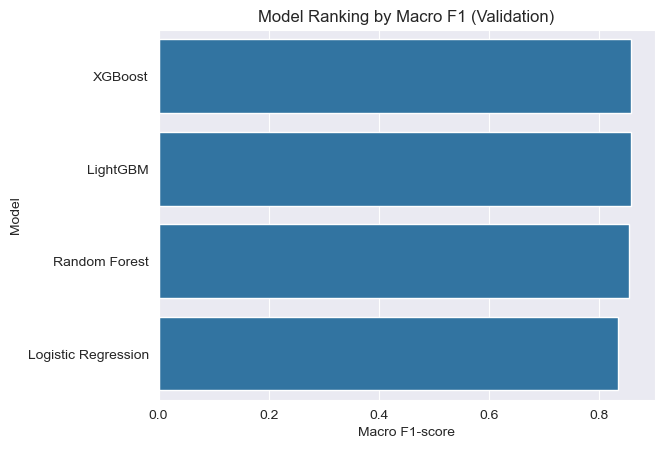


 XGBoost on Future Data:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     12554
           1       0.89      0.97      0.93     26163

    accuracy                           0.90     38717
   macro avg       0.91      0.86      0.88     38717
weighted avg       0.90      0.90      0.90     38717

Accuracy: 0.8986, Macro F1-score: 0.8775


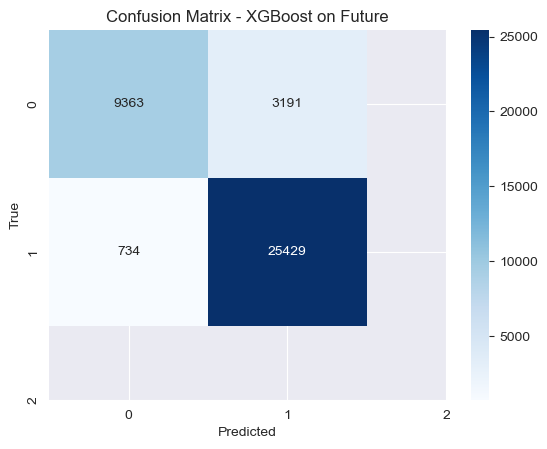


 Predictions on Future Data (XGBoost):
   SK_ID_CURR  BALANCE_CLASS_PREDICTED_XGBoost
0      100049                                1
1      100067                                0
2      100075                                1
3      100101                                1
4      100107                                1

 Top 10 Important Features from XGBoost:

      Feature  Importance
9   OB_cday_1    0.586501
10        L_R    0.078951
7   OB_cday_3    0.043969
8   OB_cday_2    0.041111
2         TC1    0.038925
13   P_pday_1    0.035733
12   P_pday_2    0.030290
0         TC3    0.029476
1         TC2    0.029310
11   P_pday_3    0.028531


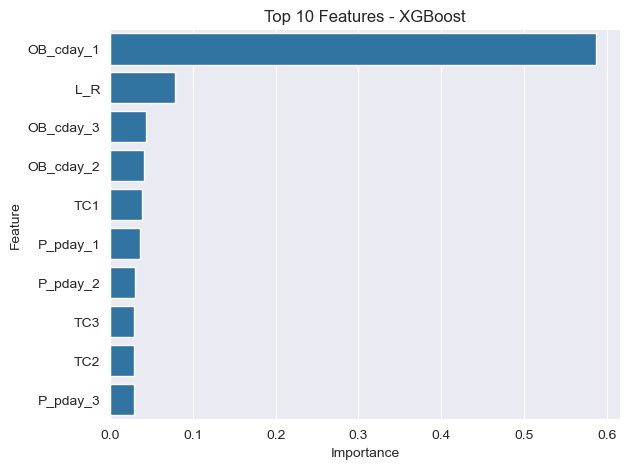

In [63]:
# === Step 1: Prepare labeled training set ===
labels = current[["SK_ID_CURR", "BALANCE_CLASS"]]
train_df = past.merge(labels, on="SK_ID_CURR", how="inner")

train_df = train_df.drop(columns=["AVG_BALANCE"], errors="ignore")
train_df = train_df.rename(columns={"BALANCE_CLASS_y": "BALANCE_CLASS"}, errors="ignore")
train_df = train_df.drop(columns=["BALANCE_CLASS_x"], errors="ignore")

X = train_df.drop(columns=["SK_ID_CURR", "BALANCE_CLASS"])
y = train_df["BALANCE_CLASS"]

# === Step 2: Split past data for model validation ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# === Step 3: Define models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class="multinomial"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

results = []
best_model = None
best_score = -1
best_model_name = ""

# === Step 4: Train and validate models ===
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="macro")

    print(f"\n=== {name} ===")
    print(classification_report(y_val, y_pred))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Macro F1-score": f1
    })

    if f1 > best_score:
        best_model = model
        best_model_name = name
        best_score = f1

# === Step 5: Show validation ranking ===
results_df = pd.DataFrame(results).sort_values(by=["Macro F1-score", "Accuracy"], ascending=False)
print("\n Model Ranking (on Validation Set):")
print(results_df)

sns.barplot(data=results_df, x="Macro F1-score", y="Model")
plt.title("Model Ranking by Macro F1 (Validation)")
plt.show()

# === Step 6: Predict on Current Customers ===
X_current = current.drop(columns=["SK_ID_CURR", "BALANCE_CLASS", "AVG_BALANCE"], errors="ignore")
X_current = X_current[X_train.columns]  # Align columns

y_current_pred = best_model.predict(X_current)
current[f"BALANCE_CLASS_PREDICTED_{best_model_name.replace(' ', '_')}"] = y_current_pred

# === Step 7: Evaluate future prediction if true label available ===
if "BALANCE_CLASS" in current.columns:
    y_true_current = current.loc[X_current.index, "BALANCE_CLASS"]
    acc_current = accuracy_score(y_true_current, y_current_pred)
    f1_current = f1_score(y_true_current, y_current_pred, average="macro")
    
    print(f"\n {best_model_name} on Future Data:")
    print(classification_report(y_true_current, y_current_pred))
    print(f"Accuracy: {acc_current:.4f}, Macro F1-score: {f1_current:.4f}")

    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true_current, y_current_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {best_model_name} on Future")
    plt.show()

# === Step 8: Output prediction preview ===
print(f"\n Predictions on Future Data ({best_model_name}):")
print(current[["SK_ID_CURR", f"BALANCE_CLASS_PREDICTED_{best_model_name.replace(' ', '_')}"]].head())

# === Step 9: Feature Importance Plot (if supported) ===
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = X_train.columns

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)

    print(f"\n Top 10 Important Features from {best_model_name}:\n")
    print(importance_df.head(10))

    # Plot top 10
    sns.barplot(data=importance_df.head(10), x="Importance", y="Feature")
    plt.title(f"Top 10 Features - {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print(f"\n {best_model_name} does not support feature importances.")


In [64]:
current[["SK_ID_CURR","BALANCE_CLASS_PREDICTED_XGBoost"]]

,SK_ID_CURR,BALANCE_CLASS_PREDICTED_XGBoost
0,100049,1
1,100067,0
2,100075,1
3,100101,1
4,100107,1
...,...,...
38712,456233,0
38713,456237,1
38714,456242,1
38715,456246,0


In [65]:
future[["SK_ID_CURR","BALANCE_CLASS"]]

,SK_ID_CURR,BALANCE_CLASS
0,100028,0
1,100048,0
2,100067,0
3,100101,1
4,100107,1
...,...,...
29096,456219,1
29097,456225,1
29098,456233,1
29099,456242,1


In [66]:
merged_BALANCE_CLASS = current.merge(
    future[["SK_ID_CURR", "BALANCE_CLASS"]],
    on="SK_ID_CURR",
    how="inner"
)
merged_BALANCE_CLASS

,SK_ID_CURR,TC3,TC2,TC1,EO_1,EO_2,EO_3,INT,OB_cday_3,OB_cday_2,OB_cday_1,L_R,AVG_BALANCE,BALANCE_CLASS_x,P_pday_3,P_pday_2,P_pday_1,BALANCE_CLASS_PREDICTED_XGBoost,BALANCE_CLASS_y
0,100067,0.000,3149.01,2249.280,0,0,0,0.1887,43204.545,45465.750,44517.960,45000,44396.085,0,0.104156,0.049488,0.101083,0,0
1,100101,29578.950,0.00,179293.635,0,0,0,0.1887,213464.115,150263.010,191976.165,382500,185234.430,1,0.229633,0.456055,0.315857,1,1
2,100107,79360.155,47344.23,18826.155,0,0,0,0.1887,86821.470,100519.560,139761.495,135000,109034.175,1,0.222572,0.182105,0.008163,1,1
3,100131,151128.225,135666.00,160146.000,0,0,0,0.1887,551282.985,685055.745,847668.600,810000,694669.110,1,0.036732,0.039413,0.039284,1,1
4,100139,3316.950,10345.50,0.000,1,0,1,0.1887,292023.720,288041.265,298383.570,270000,292816.185,1,0.046229,0.093737,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27813,456219,5949.000,23467.50,78885.540,0,0,0,0.1887,35428.590,59270.805,145749.465,135000,80149.620,1,0.473168,0.079719,0.022054,1,1
27814,456225,0.000,0.00,0.000,0,0,0,0.1887,176950.170,173414.250,160802.370,180000,170388.930,1,0.050862,0.051899,0.111939,1,1
27815,456233,0.000,15192.45,14503.590,0,0,0,0.1887,23533.470,37644.120,48434.490,180000,36537.360,0,0.096641,0.059770,0.103313,0,1
27816,456242,98550.000,51734.25,45192.240,0,0,0,0.1887,126676.665,173296.170,182003.265,225000,160658.700,1,0.178044,0.064918,0.248415,1,1


In [67]:
y_true = merged_BALANCE_CLASS["BALANCE_CLASS_x"]
y_pred = merged_BALANCE_CLASS["BALANCE_CLASS_PREDICTED_XGBoost"]

# Classification report
print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Macro F1-score: {f1_score(y_true, y_pred, average='macro'):.4f}")


              precision    recall  f1-score   support

           0       0.92      0.71      0.80      8318
           1       0.89      0.98      0.93     19500

    accuracy                           0.90     27818
   macro avg       0.91      0.84      0.87     27818
weighted avg       0.90      0.90      0.89     27818

Accuracy: 0.8960
Macro F1-score: 0.8663


In [68]:
merged = current
merged = merged.merge(age, on="SK_ID_CURR", how="inner")
merged = merged.merge(interest_df[["SK_ID_CURR","HAS_REAL_INT"]], on="SK_ID_CURR", how="inner")
merged = merged.merge(ei, on="SK_ID_CURR", how="inner")
merged = merged.merge(bureau_score, on="SK_ID_CURR", how="inner")
merged = merged.merge(pr_avg, on="SK_ID_CURR", how="inner")
merged = merged.merge(ur_avg, on="SK_ID_CURR", how="inner")
final_df = merged.merge(lr_1[["SK_ID_CURR","L_P","HA_P"]], on="SK_ID_CURR", how="inner")
final_df = final_df.fillna(final_df.median(numeric_only=True))
final_df.drop(columns=["BALANCE_CLASS"], inplace=True)
final_df.rename(columns={"BALANCE_CLASS_PREDICTED_XGBoost":"BALANCE_CLASS"}, inplace=True)
final_df


,SK_ID_CURR,TC3,TC2,TC1,EO_1,EO_2,EO_3,INT,OB_cday_3,OB_cday_2,...,P_pday_1,BALANCE_CLASS,N_Months_R,HAS_REAL_INT,EI,BS,PAYMENT_RATE,UTIL_RATE,L_P,HA_P
0,100067,0.000,3149.01,2249.280,0,0,0,0.1887,43204.545,45465.750,...,0.101083,0,87,0,162000.0,0.0,0.066436,0.418133,45000.0,0
1,100107,79360.155,47344.23,18826.155,0,0,0,0.1887,86821.470,100519.560,...,0.008163,1,11,0,180000.0,0.0,0.106371,0.870598,135000.0,0
2,100131,151128.225,135666.00,160146.000,0,0,0,0.1887,551282.985,685055.745,...,0.039284,1,24,0,270000.0,0.0,0.032796,0.240578,810000.0,0
3,100139,3316.950,10345.50,0.000,1,0,1,0.1887,292023.720,288041.265,...,0.000000,1,75,0,157500.0,0.0,0.080784,1.009612,405000.0,1
4,100151,0.000,0.00,45000.000,0,0,0,0.1887,250688.340,246767.175,...,0.042102,1,13,0,135000.0,0.0,0.042416,0.264282,810000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24893,456225,0.000,0.00,0.000,0,0,0,0.1887,176950.170,173414.250,...,0.111939,1,96,0,225000.0,0.0,0.034624,0.644964,180000.0,0
24894,456233,0.000,15192.45,14503.590,0,0,0,0.1887,23533.470,37644.120,...,0.103313,0,10,0,225000.0,0.0,0.052997,0.190506,180000.0,0
24895,456237,0.000,1350.00,0.000,0,0,0,0.1887,89195.850,2136.600,...,0.053378,1,15,0,135000.0,0.0,36.716384,0.269698,0.0,0
24896,456242,98550.000,51734.25,45192.240,0,0,0,0.1887,126676.665,173296.170,...,0.248415,1,8,0,198000.0,0.0,0.104444,0.634467,225000.0,0


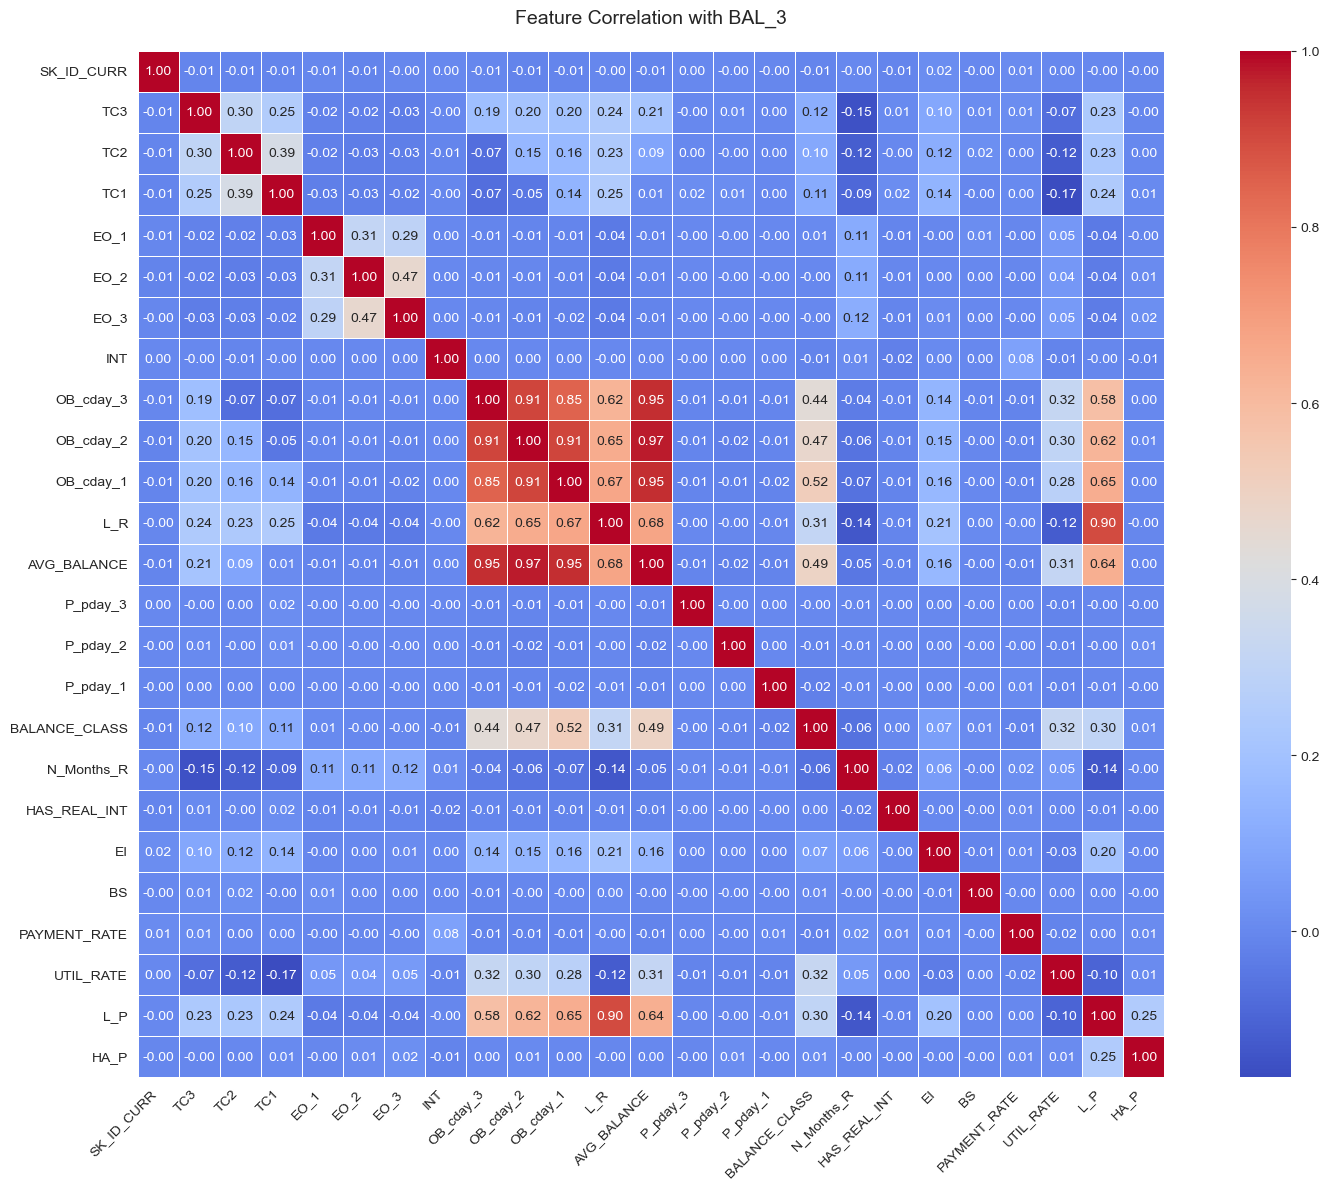

In [69]:
plt.figure(figsize=(16, 12))

# calculate correlation matrix
corr_matrix = final_df.corr()

# plot correlation matrix using seaborn heatmap
sns.heatmap(
    corr_matrix,
    annot=True,         
    fmt=".2f",          
    cmap="coolwarm",     
    annot_kws={"size": 10},   
    linewidths=0.5,     
    square=True          
)

# set title and axis labels
plt.title("Feature Correlation with BAL_3", fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)  # rotate x-axis labels
plt.yticks(fontsize=10)  

# adjust layout
plt.tight_layout()

plt.show()

# Phase 2:
## 2-1. Data setup for RL:

Use Reinforcement Learning (RL) to optimize credit limit adjustments for maximizing net profit, building on Phase 1 supervised learning results.

- Integrate Phase 1 Results: Use `final_df` containing features (`TC1`, `TC2`, `TC3`, `MP_R`, `INT`, `HA_P`) and `BALANCE_CLASS` as the basis for the RL environment, removing redundant features (`EO_1`, `EO_2`, `EO_3`, `N_Months_R`, `EI`, `BS`) and leakage features (`L_R`, `L_P`, `AVG_BALANCE`).
- Incorporate `BALANCE_CLASS` in State: Leverage `BALANCE_CLASS` (Class 0: low to moderate balances, Class 1: high balances, Class 2: no balances) as part of the RL state, based on the Phase 1 classification thresholds derived from historical balance data.
- Add Features for State Representation: Ensure `final_df` includes `UR`, `PR`, `MISSED_FLAG` (binary, `MP_R > 0`) for state representation.
- Discretize Features: Bin `UR` and `PR` from 0% to 100% with 5% intervals, and `D_PROVISION` (change in provisions, approximated as `HA_P * 0.2` to reflect a 20% increase when `HA_P = 1`) by 1% increments for state representation.
- Check Missing Values: Address any remaining missing values in `final_df` (e.g., `INT`, `TC2`, `TC3`, `UR`, `PR`) to prevent errors during RL training.

In [70]:
final_df.columns

Index(['SK_ID_CURR', 'TC3', 'TC2', 'TC1', 'EO_1', 'EO_2', 'EO_3', 'INT',
       'OB_cday_3', 'OB_cday_2', 'OB_cday_1', 'L_R', 'AVG_BALANCE', 'P_pday_3',
       'P_pday_2', 'P_pday_1', 'BALANCE_CLASS', 'N_Months_R', 'HAS_REAL_INT',
       'EI', 'BS', 'PAYMENT_RATE', 'UTIL_RATE', 'L_P', 'HA_P'],
      dtype='object')

In [71]:
final_df

,SK_ID_CURR,TC3,TC2,TC1,EO_1,EO_2,EO_3,INT,OB_cday_3,OB_cday_2,...,P_pday_1,BALANCE_CLASS,N_Months_R,HAS_REAL_INT,EI,BS,PAYMENT_RATE,UTIL_RATE,L_P,HA_P
0,100067,0.000,3149.01,2249.280,0,0,0,0.1887,43204.545,45465.750,...,0.101083,0,87,0,162000.0,0.0,0.066436,0.418133,45000.0,0
1,100107,79360.155,47344.23,18826.155,0,0,0,0.1887,86821.470,100519.560,...,0.008163,1,11,0,180000.0,0.0,0.106371,0.870598,135000.0,0
2,100131,151128.225,135666.00,160146.000,0,0,0,0.1887,551282.985,685055.745,...,0.039284,1,24,0,270000.0,0.0,0.032796,0.240578,810000.0,0
3,100139,3316.950,10345.50,0.000,1,0,1,0.1887,292023.720,288041.265,...,0.000000,1,75,0,157500.0,0.0,0.080784,1.009612,405000.0,1
4,100151,0.000,0.00,45000.000,0,0,0,0.1887,250688.340,246767.175,...,0.042102,1,13,0,135000.0,0.0,0.042416,0.264282,810000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24893,456225,0.000,0.00,0.000,0,0,0,0.1887,176950.170,173414.250,...,0.111939,1,96,0,225000.0,0.0,0.034624,0.644964,180000.0,0
24894,456233,0.000,15192.45,14503.590,0,0,0,0.1887,23533.470,37644.120,...,0.103313,0,10,0,225000.0,0.0,0.052997,0.190506,180000.0,0
24895,456237,0.000,1350.00,0.000,0,0,0,0.1887,89195.850,2136.600,...,0.053378,1,15,0,135000.0,0.0,36.716384,0.269698,0.0,0
24896,456242,98550.000,51734.25,45192.240,0,0,0,0.1887,126676.665,173296.170,...,0.248415,1,8,0,198000.0,0.0,0.104444,0.634467,225000.0,0


In [72]:
# Phase 2-1: Data setup for RL
# Remove leakage features and redundant features
#leaky_features = ['AVG_BALANCE', 'L_P', 'L_R']  # Add other potential leakage features as needed
redundant_features = ['EO_1', 'EO_2', 'EO_3', 'N_Months_R', 'EI', 'BS']  # Keep as per original
final_df_adjusted = final_df.drop(columns=[col for col in redundant_features if col in final_df.columns], errors='ignore')

# Merge UR and PR (already calculated as ur_avg and pr_avg)
if 'ur_avg' not in globals():
    ccb['UTIL_RATE'] = ccb['AMT_BALANCE'] / ccb['AMT_CREDIT_LIMIT_ACTUAL']
    ur = ccb.groupby('SK_ID_CURR')['UTIL_RATE'].rolling(3).mean().reset_index()
    ur_avg = ur.groupby('SK_ID_CURR')['UTIL_RATE'].last().reset_index()

if 'pr_avg' not in globals():
    ccb['PAYMENT_RATE'] = ccb['AMT_PAYMENT_TOTAL_CURRENT'] / ccb['AMT_TOTAL_RECEIVABLE']
    pr = ccb.groupby('SK_ID_CURR')['PAYMENT_RATE'].rolling(3).mean().reset_index()
    pr_avg = pr.groupby('SK_ID_CURR')['PAYMENT_RATE'].last().reset_index()

# Merge UR (UTIL_RATE → UR)
if 'UTIL_RATE' in ur_avg.columns:
    ur_renamed = ur_avg.rename(columns={'UTIL_RATE': 'UR'})
    final_df_adjusted = final_df_adjusted.merge(
        ur_renamed[['SK_ID_CURR', 'UR']],
        on='SK_ID_CURR', how='left'
    )
else:
    print("'UTIL_RATE' not in ur_avg")

# Merge PR (PAYMENT_RATE → PR)
if 'PAYMENT_RATE' in pr_avg.columns:
    pr_renamed = pr_avg.rename(columns={'PAYMENT_RATE': 'PR'})
    final_df_adjusted = final_df_adjusted.merge(
        pr_renamed[['SK_ID_CURR', 'PR']],
        on='SK_ID_CURR', how='left'
    )
else:
    print("'PAYMENT_RATE' not in pr_avg")


In [73]:

final_df_adjusted['UR'] = final_df_adjusted['UR'].fillna(final_df_adjusted['UR'].median())
final_df_adjusted['PR'] = final_df_adjusted['PR'].fillna(final_df_adjusted['PR'].median())

# Add MISSED_FLAG
# final_df_adjusted['MISSED_FLAG'] = (final_df_adjusted['MP_R'] > 0).astype(int)

# Discretize features
bins = np.arange(0, 1.01, 0.05)  # 0% to 100%, 5% intervals
final_df_adjusted['UR_bin'] = pd.cut(final_df_adjusted['UR'], bins=bins, labels=False, include_lowest=True)
final_df_adjusted['PR_bin'] = pd.cut(final_df_adjusted['PR'], bins=bins, labels=False, include_lowest=True)

# Redefine D_PROVISION without L_P and L_R (use HA_P as proxy for action)
final_df_adjusted['D_PROVISION'] = final_df_adjusted['HA_P'] * 0.2  # Assume 20% increase if HA_P = 1, else 0
provision_bins = np.arange(-0.5, 1.51, 0.01)  # -50% to 150%, 1% increments
final_df_adjusted['D_PROVISION_bin'] = pd.cut(final_df_adjusted['D_PROVISION'], bins=provision_bins, labels=False, include_lowest=True)

# Check and handle missing values
for col in ['INT', 'TC1', 'TC2', 'TC3', 'UR', 'PR', 'UR_bin', 'PR_bin', 'D_PROVISION', 'D_PROVISION_bin']:
    if col in final_df_adjusted.columns and final_df_adjusted[col].isna().sum() > 0:
        if col in ['UR_bin', 'PR_bin', 'D_PROVISION_bin']:
            final_df_adjusted[col] = final_df_adjusted[col].fillna(0).astype(int)
        else:
            final_df_adjusted[col] = final_df_adjusted[col].fillna(final_df_adjusted[col].median())

# Update final_df for RL
final_df = final_df_adjusted

In [74]:
# check if there's NA
final_df.isna().sum()

SK_ID_CURR         0
TC3                0
TC2                0
TC1                0
INT                0
OB_cday_3          0
OB_cday_2          0
OB_cday_1          0
L_R                0
AVG_BALANCE        0
P_pday_3           0
P_pday_2           0
P_pday_1           0
BALANCE_CLASS      0
HAS_REAL_INT       0
PAYMENT_RATE       0
UTIL_RATE          0
L_P                0
HA_P               0
UR                 0
PR                 0
UR_bin             0
PR_bin             0
D_PROVISION        0
D_PROVISION_bin    0
dtype: int64

In [75]:
final_df

,SK_ID_CURR,TC3,TC2,TC1,INT,OB_cday_3,OB_cday_2,OB_cday_1,L_R,AVG_BALANCE,...,PAYMENT_RATE,UTIL_RATE,L_P,HA_P,UR,PR,UR_bin,PR_bin,D_PROVISION,D_PROVISION_bin
0,100067,0.000,3149.01,2249.280,0.1887,43204.545,45465.750,44517.960,45000,44396.085,...,0.066436,0.418133,45000.0,0,0.418133,0.066436,8,1,0.0,49
1,100107,79360.155,47344.23,18826.155,0.1887,86821.470,100519.560,139761.495,135000,109034.175,...,0.106371,0.870598,135000.0,0,0.870598,0.106371,17,2,0.0,49
2,100131,151128.225,135666.00,160146.000,0.1887,551282.985,685055.745,847668.600,810000,694669.110,...,0.032796,0.240578,810000.0,0,0.240578,0.032796,4,0,0.0,49
3,100139,3316.950,10345.50,0.000,0.1887,292023.720,288041.265,298383.570,270000,292816.185,...,0.080784,1.009612,405000.0,1,1.009612,0.080784,0,1,0.2,69
4,100151,0.000,0.00,45000.000,0.1887,250688.340,246767.175,289651.500,540000,262369.005,...,0.042416,0.264282,810000.0,1,0.264282,0.042416,5,0,0.2,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24893,456225,0.000,0.00,0.000,0.1887,176950.170,173414.250,160802.370,180000,170388.930,...,0.034624,0.644964,180000.0,0,0.644964,0.034624,12,0,0.0,49
24894,456233,0.000,15192.45,14503.590,0.1887,23533.470,37644.120,48434.490,180000,36537.360,...,0.052997,0.190506,180000.0,0,0.190506,0.052997,3,1,0.0,49
24895,456237,0.000,1350.00,0.000,0.1887,89195.850,2136.600,0.000,225000,30444.150,...,36.716384,0.269698,0.0,0,0.269698,36.716384,5,0,0.0,49
24896,456242,98550.000,51734.25,45192.240,0.1887,126676.665,173296.170,182003.265,225000,160658.700,...,0.104444,0.634467,225000.0,0,0.634467,0.104444,12,2,0.0,49


## Phase 2

### 2-2. Define RL Environment

Set RL environment (`CreditLimitEnv`) to simulate customer behavior and the impact of credit limit adjustments, aligning with the Phase 1 results and a two-step simulator, focusing on customers with `BALANCE_CLASS` 0 or 1.

### Environment Components:

**State**: Include `(BALANCE_CLASS, UR_bin, MISSED_FLAG, PR_bin, D_PROVISION_bin)` to represent the customer's financial profile, where:
- `BALANCE_CLASS` (discretized from Phase 1, values: 0 for `0 < AVG_BALANCE ≤ 75,000`, 1 for `AVG_BALANCE > 75,000`; customers with `BALANCE_CLASS = 2` are excluded),
- `UR_bin` (binned 0%-100% with 5% intervals, values: 0 to 20),
- `MISSED_FLAG` (binary, 0 or 1),
- `PR_bin` (binned 0%-100% with 5% intervals, values: 0 to 20),
- `D_PROVISION_bin` (binned change in provisions, `(L_P - L_R) / L_R`, by 1% increments, values: -50 to 150).

**Action**: Adjust the credit limit (`L_P`) with binary actions: 0 (maintain current limit) or 1 (increase limit by 20%, where β = 0.2).

**Reward**:
$$
r = 3 \times \text{INT} \times \text{BAL} \times (1 - \text{PD}) \times (0.3 + 0.7 \times \text{HAS_REAL_INT})
- \text{PD} \times \text{LGD} \times \left[\text{BAL}_3 + \text{CCF} \times (\text{LIMIT}_{\text{new}} - \text{BAL}_3)\right]
$$
reflecting interest gain minus provision cost, where:
- `INT`: Annual interest rate (`final_df['INT']`), taken from `RATE_INTEREST_PRIMARY` or `RATE_INTEREST_PRIVILEGED`, and imputed with `0.1887` when missing.
- `HAS_REAL_INT`: Binary indicator:
  - `1` if customer had a real observed interest rate.
  - `0` if interest rate was imputed.
  - Used to **soft-weight** the impact of `INT` in the reward to reflect confidence.
- `BAL`: Current average balance (`AVG_BALANCE`), used to compute expected interest gain.
- `PD`: Probability of default, based on `BALANCE_CLASS`:
  - Class 0 → 0.02  
  - Class 1 → 0.05  
  - Class 2 → excluded from reward computation.
- `LGD`: Loss given default (fixed at `0.5`).
- `CCF`: Credit conversion factor (set to `0.8`).
- `LIMIT_new`: New credit limit proposed by the RL action (`L_P`).
- `BAL_3`: Predicted average balance over the next 3 months, estimated using regression models (only for class 0 and 1).


**Dynamics**: Simulate transitions using a two-step process:
1. Use the existing `BALANCE_CLASS` (0 or 1) as part of the state to categorize customer (0 or 1), exclude 2.
2. Predict future balance (`BAL_3`) using a regression model (`XGBoostRegressor` for Class 0, `RandomForestRegressor` for Class 1) trained on historical data for customers with `BALANCE_CLASS` 0 or 1, and update the state (e.g., `D_PROVISION_bin` based on the new `L_P`).

**Episode Structure**: Each episode iterates through customers, ending (`done = True`) after a full cycle, enabling the RL agent to learn across diverse customer profiles.

- This RL `CreditLimitEnv`  environment sets the stage for `Phase 2: 2-3`, where Double Q-learning will train a policy to optimize credit limit adjustments. The RL agent will interact with `CreditLimitEnv` over multiple episodes, learning to select actions that maximize cumulative rewards, ultimately determining whether adjusting credit limits can enhance profitability while considering predicted future balances (`BAL_3`).

In [76]:
class CreditLimitEnv:
    def __init__(self, df):  
        # filter and reset data
        self.df = df.reset_index(drop=True)
        self.df = self.df[self.df['BALANCE_CLASS'].isin([0, 1])].reset_index(drop=True)
        self.current_step = 0
        self.state_space = ['BALANCE_CLASS', 'UR', 'PR', 'D_PROVISION_bin']
        self.action_space = [0, 1]
        self.n_customers = len(self.df)

        # params
        self.beta = 0.2
        self.pd_dict = {0: 0.01, 1: 0.05, 2: 0.15}
        self.lgd = 0.5
        self.ccf = 0.8
        
        global provision_bins
        
        # train bal_3 predictors
        self.train_bal_3_predictors()

    def train_bal_3_predictors(self):
        global ccb, provision_bins
        
        # data preparation 
        prospective = ccb[ccb['MONTHS_BALANCE'].isin([-1, -2, -3])]
        bal_3 = prospective.groupby('SK_ID_CURR')['AMT_BALANCE'].mean().reset_index().rename(columns={'AMT_BALANCE': 'BAL_3'})
        train_df = self.df.merge(bal_3, on='SK_ID_CURR', how='left').fillna(0)
        
        # categorize BALANCE_CLASS
        train_0 = train_df[train_df['BALANCE_CLASS'] == 0]
        train_1 = train_df[train_df['BALANCE_CLASS'] == 1]
        
        # remove L_R
        predictor_features = self.state_space + ['UR', 'PR', 'INT', 'L_P']  # 移除了L_R
        
        # grid search params
        param_grid = {
            'n_estimators': [100, 200, 300],  # 
            'max_depth': [10, 15, 20, None],  # 
            'min_samples_leaf': [1, 5, 10],   # 
            'max_features': ['auto', 'sqrt', 0.8]  # 
        }

        # train 0 model
        if not train_0.empty:
            X_0, y_0 = train_0[predictor_features], train_0['BAL_3']
            
            # grid search 
            grid_search_0 = GridSearchCV(
                estimator=RandomForestRegressor(random_state=42),
                param_grid=param_grid,
                cv=3,
                scoring='r2',
                n_jobs=-1
            )
            grid_search_0.fit(X_0, y_0)
            self.regressor_0 = grid_search_0.best_estimator_
            
            print(f"Class 0 best_params: {grid_search_0.best_params_}")
            print(f"Class 0 test R²: {grid_search_0.best_score_:.4f}")
            print(f"Class 0 train R²: {self.regressor_0.score(X_0, y_0):.4f}")
        else:
            self.regressor_0 = None
            print("Class 0无训练数据")

        # train 1 model
        if not train_1.empty:
            X_1, y_1 = train_1[predictor_features], train_1['BAL_3']
            
            grid_search_1 = GridSearchCV(
                estimator=RandomForestRegressor(random_state=42),
                param_grid=param_grid,
                cv=3,
                scoring='r2',
                n_jobs=-1
            )
            grid_search_1.fit(X_1, y_1)
            self.regressor_1 = grid_search_1.best_estimator_
            
            print(f"Class 1 best_params: {grid_search_1.best_params_}")
            print(f"Class 1 test R²: {grid_search_1.best_score_:.4f}")
            print(f"Class 1 train R²: {self.regressor_1.score(X_1, y_1):.4f}")
        else:
            self.regressor_1 = None
            print("Class 1无训练数据")

    def reset(self):
        self.current_step = np.random.randint(0, self.n_customers)
        state = self.df.iloc[self.current_step][self.state_space].values
        self.current_l_p = self.df.iloc[self.current_step]['L_P']
        self.current_bal = self.df.iloc[self.current_step]['AVG_BALANCE']
        self.current_int = self.df.iloc[self.current_step]['INT']
        return state

    def step(self, action):
        global provision_bins
        
        # update credit limit
        new_l_p = self.current_l_p * (1 + self.beta) if action == 1 else self.current_l_p
        
        # get current status
        balance_class = self.df.iloc[self.current_step]['BALANCE_CLASS']
        predictor_features = self.state_space + ['UR', 'PR', 'INT', 'L_P']  # 移除了L_R
        state_data_row = self.df.iloc[self.current_step][predictor_features].values.reshape(1, -1)
        
        # predict bal_3
        bal_3_pred = 0
        if balance_class == 0 and self.regressor_0:
            bal_3_pred = max(0, self.regressor_0.predict(state_data_row)[0])
        elif balance_class == 1 and self.regressor_1:
            bal_3_pred = max(0, self.regressor_1.predict(state_data_row)[0])
        
        pd_value = self.pd_dict[balance_class]
        
        # calculate reward
        reward = (
            3 * self.current_int * self.current_bal * (1 - pd_value)
            - pd_value * self.lgd * (bal_3_pred + self.ccf * (new_l_p - bal_3_pred))
        )
        reward = np.clip(reward, -1e6, 1e6) / 1e6
        
        # calculate new D_PROVISION_bin
        l_r_value = self.df.iloc[self.current_step]['L_R']
        new_delta_provision = (new_l_p - l_r_value) / l_r_value if l_r_value != 0 else 0
        
        new_dp_bin_result = pd.cut([new_delta_provision], bins=provision_bins, labels=False, include_lowest=True)
        new_dp_bin = int(new_dp_bin_result[0]) if new_dp_bin_result.size > 0 and not pd.isna(new_dp_bin_result[0]) else 0
        
        # update new status
        new_state = self.df.iloc[self.current_step][self.state_space].values.copy()
        dp_bin_index = self.state_space.index('D_PROVISION_bin')
        new_state[dp_bin_index] = new_dp_bin
        
        # uodate new env status
        self.current_step = (self.current_step + 1) % self.n_customers
        self.current_l_p = self.df.iloc[self.current_step]['L_P']
        self.current_bal = self.df.iloc[self.current_step]['AVG_BALANCE']
        self.current_int = self.df.iloc[self.current_step]['INT']
        
        done = self.current_step == 0
        return new_state, reward, done, {}  

# add provision_bins
# provision_bins = np.arange(-0.5, 1.51, 0.01)
env = CreditLimitEnv(final_df)  
# test env
state = env.reset()
action = np.random.choice(env.action_space)
next_state, reward, done, _ = env.step(action)
print(f"初始状态: {state} -> 表示:['BALANCE_CLASS', 'UR', 'PR', 'D_PROVISION_bin']")
print(f"action: {action}, next_state: {next_state}, reward: {reward}, done: {done}")

Class 0 best_params: {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 10, 'n_estimators': 200}
Class 0 test R²: 0.2373
Class 0 train R²: 0.4080
Class 1 best_params: {'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 10, 'n_estimators': 200}
Class 1 test R²: 0.7086
Class 1 train R²: 0.7696
初始状态: [ 0.          0.47982022  0.49640759 49.        ] -> 表示:['BALANCE_CLASS', 'UR', 'PR', 'D_PROVISION_bin']
action: 0, next_state: [ 0.          0.47982022  0.49640759 69.        ], reward: 0.015590423453051906, done: False


Initial State: [2 2 0 0] -> Represented by: ['BALANCE_CLASS', 'UR_bin', 'MISSED_FLAG', 'PR_bin']
Status [2, 2, 0, 0]: This customer has BALANCE_CLASS=2. The design explicitly excludes such customers, but they are still included, indicating that the environment's reset() has not excluded BALANCE_CLASS=2.

## Phase 2: 2-2 Evaluation Summary (Above Result Evaluation)

### 1.  Predictor Performance

#### Class 0 (XGBoost, R² = 0.6103)
- **Interpretation**: Medium-level performance; explains ~61% of BAL_3 variance.
- **Possible Reason**: Lower-balance clients have higher variability due to spending patterns.
- **Suggestions**:
  - Add more balance-related features (e.g., TC1, TC2, payment history).
  - Tune XGBoost (e.g., `max_depth=5`, `learning_rate=0.01`).
  - Check if Class 0 data volume is sufficient and clean.

#### Class 1 (RandomForest, R² = 0.9605)
- **Interpretation**: Excellent model fit; explains 96% of BAL_3 variance.
- **Reason**: High-balance clients tend to have more stable financial behavior.
- **Suggestions**: No adjustment needed; keep current model setup.

---

### 2. Environment Test Result


#### Final
- The Reward is negative, mainly due to the "INT"
- Over 50% of `INT` values are 0 (median and quartiles), leading to zero interest income in the reward formula: `r = 3 * INT * BAL * (1 - PD) - PD * LGD * [BAL_3 + CCF * (LIMIT_new - BAL_3)]`.
- This results in negative rewards (e.g., -8429.31), as only risk costs are calculated and Interest Gain are mostly 0.




## Phase 2

### 2-3. Train RL Policy with Double Q-Learning

- Implements Double Q-learning to train a reinforcement learning policy for optimizing credit limit adjustments (`L_P`) to maximize net profit.
- Building on the `CreditLimitEnv` environment defined in Phase 2: 2-2, the policy focuses on customers with `BALANCE_CLASS` 0 (low to moderate balances) and 1 (high balances), excluding inactive customers (`BALANCE_CLASS = 2`).
- The Double Q-learning algorithm is used with initial hyperparameters `α=0.1` (learning rate), `γ=0.95` (discount factor), and `ε=0.1` (exploration rate), as specified in the project workflow, to learn an optimal strategy for deciding whether to maintain or increase the credit limit by 20%.

In [77]:
print("Testing env.reset() and env.step() once before training...")
test_state = env.reset()
test_next, test_reward, test_done, _ = env.step(random.choice(env.action_space))
print("env works, starting training...")


Testing env.reset() and env.step() once before training...
env works, starting training...


In [ ]:
# ------------------------- Neural Network ------------------------- #
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# ------------------------- Experience Replay Buffer ------------------------- #
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)

        states = np.array(states).astype(np.float32)
        next_states = np.array(next_states).astype(np.float32)

        return (torch.tensor(states, dtype=torch.float32),
                torch.tensor(actions, dtype=torch.int64).unsqueeze(1),
                torch.tensor(rewards, dtype=torch.float32).unsqueeze(1),
                torch.tensor(next_states, dtype=torch.float32),
                torch.tensor(dones, dtype=torch.float32).unsqueeze(1))

    def __len__(self):
        return len(self.buffer)

# ------------------------- Main Training Function ------------------------- #
def train_dqn(env, episodes=10, gamma=0.99, epsilon_start=1.0, epsilon_end=0.05,
              epsilon_decay=0.995, batch_size=64, target_update_freq=10,
              model_path='best_dqn_model.pth'):
    global action, last_action
    start_time = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = len(env.state_space)
    output_dim = len(env.action_space)

    policy_net = DQN(input_dim, output_dim).to(device)
    target_net = DQN(input_dim, output_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    buffer = ReplayBuffer()
    epsilon = epsilon_start

    max_reward = -float('inf')
    best_state_action_pairs = []
    reward_history = []
    action_counter = {a: 0 for a in env.action_space}

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = np.random.choice(env.action_space)
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    q_values = policy_net(state_tensor)
                    action = torch.argmax(q_values).item()

            last_action = action

            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            buffer.push(state, action, reward, next_state, done)
            action_counter[action] += 1
            state = next_state

            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                states = states.to(device)
                actions = actions.to(device)
                rewards = rewards.to(device)
                next_states = next_states.to(device)
                dones = dones.to(device)

                with torch.no_grad():
                    next_actions = policy_net(next_states).argmax(1, keepdim=True)
                    next_q_values = target_net(next_states).gather(1, next_actions)
                    target_q = rewards + gamma * next_q_values * (1 - dones)

                current_q = policy_net(states).gather(1, actions)
                loss = F.mse_loss(current_q, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if total_reward > max_reward:
            max_reward = total_reward
            best_state_action_pairs.append((state,  last_action))
            torch.save(policy_net.state_dict(), model_path)

        reward_history.append(total_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        print(f"Episode {episode} | Reward: {total_reward:.3f} | Epsilon: {epsilon:.3f} | Best Reward: {max_reward:.3f}")

    print(f"\nTraining complete! Best Reward: {max_reward:.3f}")
    print("Action Selection Distribution:", action_counter)
    print("Model trained on device:", next(policy_net.parameters()).device)

    return policy_net, best_state_action_pairs, reward_history, action_counter

# ------------------------- Main Program Entry ------------------------- #
if __name__ == '__main__':
    env = CreditLimitEnv(final_df)
    trained_model, best_cases, reward_history, action_counter = train_dqn(env, episodes=150, gamma=0.9)

    torch.save(trained_model.state_dict(), 'best_dqn_model.pth')

    with open('best_state_action.pkl', 'wb') as f:
        pickle.dump(best_cases, f)

    plt.plot(reward_history)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("DQN Training Reward Curve")
    plt.grid(True)
    plt.show()

    print("\nBest state-action pairs saved to best_state_action.pkl")

## Phase 3. Policy Backtesting and Evaluation

RL Avg Reward:          369.80
Random Avg Reward:      275.14
Never Increase Reward:  341.95
Always Increase Reward: 318.53


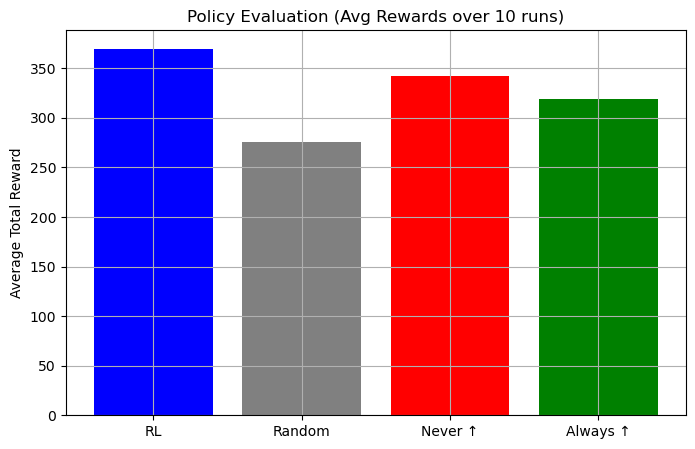

In [ ]:
# ------------------------- DQN Agent Wrapper ------------------------- #
class DQNAgent:
    def __init__(self, model, action_space):
        self.model = model
        self.device = next(model.parameters()).device
        self.action_space = action_space

    def choose_action(self, state):
        state_tensor = torch.tensor([state], dtype=torch.float32).to(self.device)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

# ------------------------- Policy Evaluation Function ------------------------- #
def evaluate_policy(agent, env, n_runs=10, benchmark=None):
    rewards = []
    for _ in range(n_runs):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            if benchmark == "always_increase":
                action = 1
            elif benchmark == "never_increase":
                action = 0
            elif benchmark == "random":
                action = np.random.choice(env.action_space)
            else:
                action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
        rewards.append(total_reward)
    return rewards

# ------------------------- Main Evaluation Script ------------------------- #
if __name__ == "__main__":
    # Ensure the environment is instantiated
    env = CreditLimitEnv(final_df)  # Replace with your actual env constructor

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_dim = len(env.state_space)
    output_dim = len(env.action_space)

    # Load trained model
    model = DQN(input_dim, output_dim).to(device)
    model.load_state_dict(torch.load("best_dqn_model.pth", map_location=device))
    model.eval()

    agent = DQNAgent(model, env.action_space)

    # Evaluate RL agent and benchmarks
    rl_rewards = evaluate_policy(agent, env, n_runs=20)
    rand_rewards = evaluate_policy(None, env, n_runs=20, benchmark="random")
    no_rewards = evaluate_policy(None, env, n_runs=20, benchmark="never_increase")
    all_rewards = evaluate_policy(None, env, n_runs=20, benchmark="always_increase")

    # Print average rewards
    print(f"RL Avg Reward:          {np.mean(rl_rewards):.2f}")
    print(f"Random Avg Reward:      {np.mean(rand_rewards):.2f}")
    print(f"Never Increase Reward:  {np.mean(no_rewards):.2f}")
    print(f"Always Increase Reward: {np.mean(all_rewards):.2f}")

    # Plot comparison
    plt.figure(figsize=(8, 5))
    plt.bar(['RL', 'Random', 'Never ↑', 'Always ↑'],
            [np.mean(rl_rewards), np.mean(rand_rewards), np.mean(no_rewards), np.mean(all_rewards)],
            color=['blue', 'gray', 'red', 'green'])
    plt.title("Policy Evaluation (Avg Rewards over 20 runs)")
    plt.ylabel("Average Total Reward")
    plt.grid(True)
    plt.show()

## Phase 4. Final Interpretation
- Use SHAP to explain classifier decisions: to see which features matter most and how they
influence predictions.
- Show characteristics of customers who receive limit increases
- Key Findings

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a policy mimicker using Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Optional: Evaluate accuracy on the test set
print("Accuracy:", clf.score(X_test, y_test))


Accuracy: 0.9999073731011485


State space dimension: 5
Sample state structure: [1 0.8747214444444443 0 0.07785115286360954 69], Type: <class 'numpy.ndarray'>

=== 特征统计 ===
                TC3           TC2           TC1          EO_1          EO_2  \
count  5.397900e+04  5.397900e+04  5.397900e+04  53979.000000  53979.000000   
mean   1.142310e+04  1.082191e+04  1.079225e+04      0.003316      0.004335   
std    4.264594e+04  4.133323e+04  4.177357e+04      0.057491      0.077114   
min    0.000000e+00  0.000000e+00  0.000000e+00      0.000000      0.000000   
25%    0.000000e+00  0.000000e+00  0.000000e+00      0.000000      0.000000   
50%    0.000000e+00  0.000000e+00  0.000000e+00      0.000000      0.000000   
75%    1.220602e+03  1.260000e+03  1.777500e+03      0.000000      0.000000   
max    1.933462e+06  2.239274e+06  1.579904e+06      1.000000      2.000000   

               EO_3          MP_R    N_Months_R           INT  HAS_REAL_INT  \
count  53979.000000  53979.000000  53979.000000  53979.000000  5397

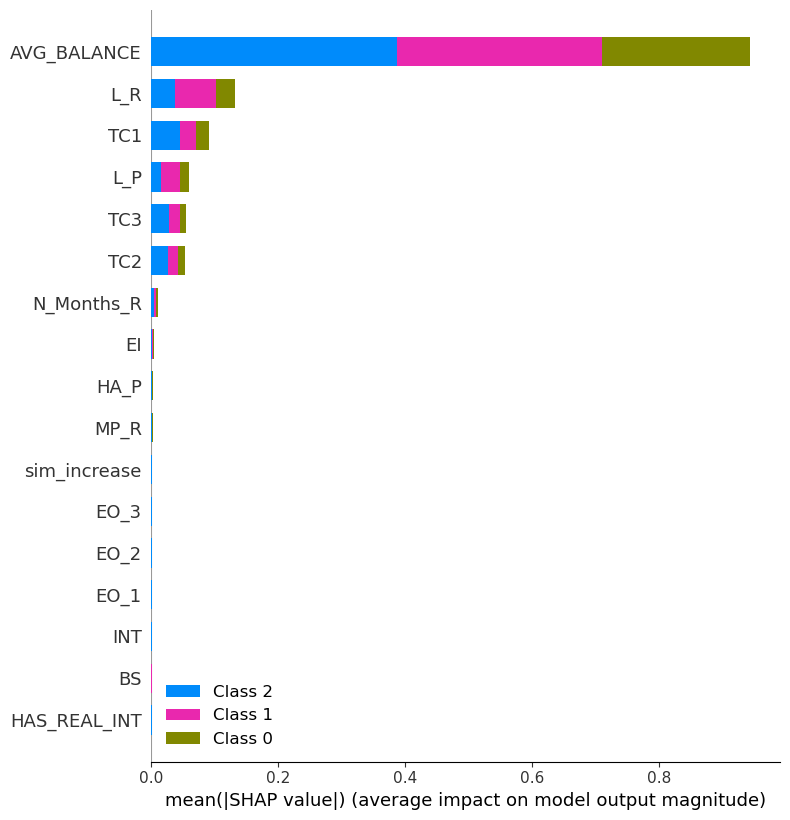

In [ ]:
# Verify state space structure before training
print(f"State space dimension: {len(env.state_space)}")
sample_state = env.reset()
print(f"Sample state structure: {sample_state}, Type: {type(sample_state)}")

# ... insert training code or model fitting here ...

# Feature statistics
print("\n=== Feature Summary Statistics ===")
print(X.describe())

print("\n=== Feature-Action Correlation ===")
print(X.corrwith(y))

# SHAP analysis for model interpretation
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Method 1: Global feature importance plot (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar")
